In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d
import scipy as sp
pd.set_option("display.max_columns", None)
from tqdm import tqdm
tqdm.pandas()

In [5]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# DATA CLEANING AND WRANGLING

In [9]:
# DF1 = Total and facet scores, and score per question
df0 = pd.read_csv('Indian Risk Survey_Besample_Filtered_12_2024.csv')
df1 = df0.iloc[:, 19:62].copy()
df1.insert(0, "ResponseId",0)
df1["ResponseId"] = df0["ResponseId"].copy()
df0 = df1.copy()
df0

ResponseId                                                 Q0  \
0    R_4RadSQzbD3kAfEP  Yes, I would like to participate in the study ...   
1    R_4F8RqnI7xnwXmBY  Yes, I would like to participate in the study ...   
2    R_8taN3wUPbeZMxzM  Yes, I would like to participate in the study ...   
3    R_4KT4eUqEbo2q5s9  Yes, I would like to participate in the study ...   
4    R_4TMr0yMiNpsJBr5  Yes, I would like to participate in the study ...   
..                 ...                                                ...   
365  R_47eRbAoGWc5Ttzb  Yes, I would like to participate in the study ...   
366  R_4eWLoP4wkX5K1kl  Yes, I would like to participate in the study ...   
367  R_47rbcPZByLBrZFn  Yes, I would like to participate in the study ...   
368  R_42y9IJJWALsuHPF  Yes, I would like to participate in the study ...   
369  R_8k6D0jzzHCC5X3Z  Yes, I would like to participate in the study ...   

       Q1  Q2                                    Q3  \
0    Male  18  Secondary School (11th to 12th Std.)   
1    Male  41                 Undergraduate Program   
2    Male  20                 Undergraduate Program   
3    Male  18  Secondary School (11th to 12th Std.)   
4    Male  37                 Undergraduate Program   
..    ...  ..                                   ...   
365  Male  48                 Post-Graduate Program   
366  Male  22                 Undergraduate Program   
367  Male  19       Diploma and Vocational Training   
368  Male  28                 Undergraduate Program   
369  Male  25                 Undergraduate Program   

                                                    Q4  \
0                                              Student   
1    Salaried/Employee/Consultant in a sector other...   
2                                              Student   
3                                              Student   
4    Salaried/Employee/Consultant in a sector other...   
..                                                 ...   
365  Salaried/Employee/Consultant in a sector other...   
366  Salaried/Employee/Consultant in a sector other...   
367                                            Student   
368  Salaried/Employee/Consultant in a sector other...   
369  Salaried/Employee/Consultant in a sector other...   

                           Q5_1                          Q6_1  \
0                             4                             7   
1                             6                             9   
2                             3  0 (no investment experience)   
3                             5  0 (no investment experience)   
4                             3                             1   
..                          ...                           ...   
365  0 (unwilling to take risk)                             1   
366                           5                             6   
367                           5                             5   
368                           6                             7   
369    7 (willing to take risk)                             8   

                   Q8_1                Q8_2                Q8_3  \
0                     3                   3                   3   
1                     4                   4                   4   
2    6 (strongly agree)  6 (strongly agree)                   4   
3    6 (strongly agree)  6 (strongly agree)                   4   
4                     4                   5                   5   
..                  ...                 ...                 ...   
365                   4                   5                   4   
366                   5                   5                   4   
367  6 (strongly agree)  6 (strongly agree)  6 (strongly agree)   
368  6 (strongly agree)                   3                   5   
369  6 (strongly agree)                   5                   5   

                      Q8_4                   Q8_5                Q8_6  \
0                        4                      5                   4 

## Demographics

In [10]:
df0["age"] = df0["Q2"]

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )


# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 5,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["wealth"] = df0["Q14b.1"]


In [11]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

In [13]:
print("Total Observations:", df0["Q1"].count())

print(f'\nGender:\n{remove_indexname(df0["Q1"].value_counts())}')
print(f'\nOccupation:\n{remove_indexname(df0["Q4"].value_counts())}')
print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts())}')
print(f'\nISCED:\n{remove_indexname(df0["isced"].value_counts())}')
print(f'\nIncome:\n{remove_indexname(df0["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]])}')

Total Observations: 370

Gender:
Male      219
Female    151

Occupation:
Salaried/Employee/Consultant in a sector other than Finance    167
Student                                                        100
Not employed                                                    50
Entrepreneur/Business Owner in a sector other than Finance      30
Stock analyst                                                   12
Insurance agent, etc                                             7
Retired                                                          3
Venture capital/private equity                                   1

Education:
Undergraduate Program                   183
Post-Graduate Program                   117
Secondary School (11th to 12th Std.)     38
Diploma and Vocational Training          18
Ph.D. and higher                          8
Primary School (up to 10th Std.)          5
M.Phil.                                   1

ISCED:
2    201
1    126
3     43

Income:
INR 500,001 – INR 15,00,00

In [21]:
df1 = df0.copy()

## Questions

In [22]:
matchCol = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5", "q8_3", "q8_4", "q8_5berlin_1", 
            "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7", "q9_1_1", "q9_2_1", "q9_3",
            "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]
df1[ matchCol ] = 0

df1.columns

Index(['ResponseId', 'Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5_1', 'Q6_1', 'Q8_1',
       'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q9b_1',
       'Q9b_4', 'Q9b_5', 'Q9b_6', 'Q9b_7', 'Q9b_8', 'Q9b_9', 'Q11a_1',
       'Q11a_2', 'Q11a_3', 'Q11b', 'Q11c', 'Q11d', 'Q11h', 'Attention Check',
       'Q11i', 'Q12a', 'Q12b', 'Q12c', 'Q13a', 'Q13b', 'Q13c', 'Q13d', 'Q14a',
       'Q14b', 'Q14c', 'Q15a', 'Q14b.1', 'age', 'age_rec', 'isced', 'income',
       'wealth', 'q8_2_1', 'q8_2_2', 'q8_2_3', 'q8_2_4', 'q8_2_5', 'q8_3',
       'q8_4', 'q8_5berlin_1', 'q8_5london_1', 'q8_5paris_1', 'q8_6', 'q8_7',
       'q9_1_1', 'q9_2_1', 'q9_3', 'q10_1_1', 'q10_2_1', 'q10_3_1', 'q10_4'],
      dtype='object')

In [15]:
df1["q8_2_1"] = np.where(df1["Q11b"].str.contains("HIV test"), 1, 2)
df1["q8_2_2"] = np.where(df1["Q11b"].str.contains("Fingerprint"), 1, 2)
df1["q8_2_3"] = np.where(df1["Q11b"].str.contains("DNA test"), 1, 2)
df1["q8_2_4"] = np.where(df1["Q11b"].str.contains("Cancer screening test"), 1, 2)
df1["q8_2_5"] = np.where(df1["Q11b"].str.contains("Professional horoscope"), 1, 2)

df1["q8_3"] = np.where(df1["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df1["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df1["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df1["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df1["q8_4"] = np.where(df1["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df1["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df1["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df1["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [16]:
df1["q8_5berlin_1"] = np.where(df1["Q11a_1"] == 1, 1, 2)
df1["q8_5london_1"] = np.where(df1["Q11a_1"] == 1, 1, 2)
df1["q8_5paris_1"] = np.where(df1["Q11a_1"] == 1, 1, 2)

df1["q8_6"] = np.where(df1["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df1["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df1["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df1["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df1["q8_7"] = np.where(df1["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df1["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df1["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df1["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df1["q9_1_1"] = df1["Q14a"].copy()
df1["q9_2_1"] = df1["Q14b"].copy()

df1["q9_3"] = np.where(df1["Q14c"] == "Crosicol", 1,
                          np.where(df1["Q14c"] == "Hertinol", 2,
                                   np.where(df1["Q14c"] == "They are equal", 3,
                                            np.where(df1["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [17]:
df1["q10_1_1"] = df1["Q13a"].copy()
df1["q10_2_1"] = df1["Q13b"].copy()
df1["q10_3_1"] = df1["Q13c"].copy()

df1["q10_4"] = np.where(df1["Q13d"] == "9 out of 59", 1,
                          np.where(df1["Q13d"] == "9 out of 10", 2,
                                   np.where(df1["Q13d"] == "59 out of 1000", 3,
                                            np.where(df1["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

In [18]:
df1["ResponseId"].nunique()

370

In [19]:
scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5", "uncertainty1", "uncertainty2", "numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5", "graph1", "graph2", "graph3", "riskcalculation1", "riskcalculation2", "riskcalculation3", "riskcalculation4"]
df1[scoreColumns] = 0

In [20]:
# Assigning scores

def scoring1(df1Facet):
    df1Facet.loc[ df1Facet["q8_2_1"] == 2, "certainty1"] = 1
    df1Facet.loc[ df1Facet["q8_2_2"] == 2, "certainty2"] = 1
    df1Facet.loc[ df1Facet["q8_2_3"] == 2, "certainty3"] = 1
    df1Facet.loc[ df1Facet["q8_2_4"] == 2, "certainty4"] = 1
    df1Facet.loc[ df1Facet["q8_2_5"] == 2, "certainty5"] = 1

    df1Facet.loc[ df1Facet["q8_3"] == 1, "uncertainty1"] = 1
    df1Facet.loc[ df1Facet["q8_4"] == 4, "uncertainty2"] = 1

    df1Facet.loc[ df1Facet["q8_5berlin_1"] == 2, "numeracy1"] = 1
    df1Facet.loc[ df1Facet["q8_5london_1"] == 1, "numeracy2"] = 1
    df1Facet.loc[ df1Facet["q8_5paris_1"] == 1, "numeracy3"] = 1
    df1Facet.loc[ df1Facet["q8_6"] == 1, "numeracy4"] = 1
    df1Facet.loc[ df1Facet["q8_7"] == 4, "numeracy5"] = 1

    df1Facet.loc[ df1Facet["q9_1_1"] == 25, "graph1"] = 1
    df1Facet.loc[ df1Facet["q9_2_1"] == 20, "graph2"] = 1
    df1Facet.loc[ df1Facet["q9_3"] == 3, "graph3"] = 1

    df1Facet.loc[ df1Facet["q10_1_1"] == 500, "riskcalculation1"] = 1
    df1Facet.loc[ df1Facet["q10_2_1"] == 10, "riskcalculation2"] = 1
    df1Facet.loc[ (df1Facet["q10_3_1"] == 0.1) | (df1Facet["q10_3_1"] == ".1") | (df1Facet["q10_3_1"] == ",1") , "riskcalculation3"] = 1
    df1Facet.loc[ df1Facet["q10_4"] == 1, "riskcalculation4"] = 1

    # Assigning total scores
    #df1Facet["Certainty score_5"] = df1Facet["certainty1"] + df1Facet["certainty2"] + df1Facet["certainty3"] + df1Facet["certainty4"] + df1Facet["certainty5"]
    #df1Facet["Uncertainty score_5"] = df1Facet["uncertainty1"] + df1Facet["uncertainty2"]

    #df1Facet["Number Comprehension score_5"] = df1Facet["numeracy1"] + df1Facet["numeracy2"] + df1Facet["numeracy3"] + df1Facet["numeracy4"] + df1Facet["numeracy5"]
    #df1Facet["Graph Comprehension score_5"] = df1Facet["graph1"] + df1Facet["graph2"] + df1Facet["graph3"]

    #df1Facet["Calculation score_4"] = df1Facet["riskcalculation1"] + df1Facet["riskcalculation2"] + df1Facet["riskcalculation3"] + df1Facet["riskcalculation4"]

    #df1Facet["Total Score_19"] = df1Facet["Certainty score_5"] + df1Facet["Uncertainty score_5"] + df1Facet["Number Comprehension score_5"] + df1Facet["Graph Comprehension score_5"] + df1Facet["Calculation score_4"]

    return df1Facet

In [17]:
df1Facet = df1.groupby(["ResponseId"]).progress_apply(scoring1)

100%|███████████████████████████████████████████████████████████████████████████████| 370/370 [00:02<00:00, 131.04it/s]


In [18]:
df1Facet

ResponseId  \
ResponseId                                 
R_1YkMM2lMB9aEuVL 150  R_1YkMM2lMB9aEuVL   
R_401xXJ9E3ZgU9gu 96   R_401xXJ9E3ZgU9gu   
R_40N8bUn3C0jwGzf 200  R_40N8bUn3C0jwGzf   
R_40VyTmJ6i96wUP4 235  R_40VyTmJ6i96wUP4   
R_40ZEg7vX3Y7mMQl 184  R_40ZEg7vX3Y7mMQl   
...                                  ...   
R_4yzFrFYMa7w8nQZ 238  R_4yzFrFYMa7w8nQZ   
R_4zPiSk23ayGvFD4 364  R_4zPiSk23ayGvFD4   
R_4zdzjECYeO2A5Ox 255  R_4zdzjECYeO2A5Ox   
R_8k6D0jzzHCC5X3Z 369  R_8k6D0jzzHCC5X3Z   
R_8taN3wUPbeZMxzM 2    R_8taN3wUPbeZMxzM   

                                                                      Q0  \
ResponseId                                                                 
R_1YkMM2lMB9aEuVL 150  Yes, I would like to participate in the study ...   
R_401xXJ9E3ZgU9gu 96   Yes, I would like to participate in the study ...   
R_40N8bUn3C0jwGzf 200  Yes, I would like to participate in the study ...   
R_40VyTmJ6i96wUP4 235  Yes, I would like to participate in the study ...   
R_40ZEg7vX3Y7mMQl 184  Yes, I would like to participate in the study ...   
...                                                                  ...   
R_4yzFrFYMa7w8nQZ 238  Yes, I would like to participate in the study ...   
R_4zPiSk23ayGvFD4 364  Yes, I would like to participate in the study ...   
R_4zdzjECYeO2A5Ox 255  Yes, I would like to participate in the study ...   
R_8k6D0jzzHCC5X3Z 369  Yes, I would like to participate in the study ...   
R_8taN3wUPbeZMxzM 2    Yes, I would like to participate in the study ...   

                           Q1  Q2                                    Q3  \
ResponseId                                                                
R_1YkMM2lMB9aEuVL 150  Female  41                 Undergraduate Program   
R_401xXJ9E3ZgU9gu 96     Male  33                 Undergraduate Program   
R_40N8bUn3C0jwGzf 200  Female  18                 Undergraduate Program   
R_40VyTmJ6i96wUP4 235  Female  34                 Post-Graduate Program   
R_40ZEg7vX3Y7mMQl 184  Female  31                 Undergraduate Program   
...                       ...  ..                                   ...   
R_4yzFrFYMa7w8nQZ 238  Female  18  Secondary School (11th to 12th Std.)   
R_4zPiSk23ayGvFD4 364    Male  70                 Undergraduate Program   
R_4zdzjECYeO2A5Ox 255  Female  19  Secondary School (11th to 12th Std.)   
R_8k6D0jzzHCC5X3Z 369    Male  25                 Undergraduate Program   
R_8taN3wUPbeZMxzM 2      Male  20                 Undergraduate Program   

                                                                      Q4  \
ResponseId                                                                 
R_1YkMM2lMB9aEuVL 150  Salaried/Employee/Consultant in a sector other...   
R_401xXJ9E3ZgU9gu 96                                       Stock analyst   
R_40N8bUn3C0jwGzf 200                                            Student   
R_40VyTmJ6i96wUP4 235                                       Not employed   
R_40ZEg7vX3Y7mMQl 184                                       Not employed   
...                                                                  ...   
R_4yzFrFYMa7w8nQZ 238                                            Student   
R_4zPiSk23ayGvFD4 364  Salaried/Employee/Consultant in a sector other...   
R_4zdzjECYeO2A5Ox 255                                            Student   
R_8k6D0jzzHCC5X3Z 369  Salaried/Employee/Consultant in a sector other...   
R_8taN3wUPbeZMxzM 2                                              Student   

                                             Q5_1  \
ResponseId                                          
R_1YkMM2lMB9aEuVL 150                           3   
R_401xXJ9E3ZgU9gu 96     7 (willing to take risk)   
R_40N8bUn3C0jwGzf 200  0 (unwilling to take risk)   
R_40VyTmJ6i96wUP4 235                           2   
R_40ZEg7vX3Y7mMQl 184                           4   
...                                           ...   
R_4yzFrFYMa7w8nQZ 238  0 (unwilling to take risk)   
R_4zPiSk23ayGvFD4 364     

In [19]:
df1 = df1Facet.copy()

In [20]:
df1["Certainty_3"] = df1["certainty1"] + df1["certainty2"] + df1["certainty3"]
df1["RiskComprehension_4"] = df1["riskcalculation1"] + df1["riskcalculation2"] + df1["riskcalculation3"] + df1["riskcalculation4"]
df1["GraphLiteracy_3"] = df1["graph1"] + df1["graph2"] + df1["graph3"]
df1["Numeracy_3"] = df1["numeracy1"] + df1["numeracy2"] + df1["numeracy3"]
df1["Bayesianreasoning_1"] = df1["numeracy4"]
df1["TotalScore_14"] = df1["Certainty_3"] + df1["RiskComprehension_4"] + df1["GraphLiteracy_3"] + df1["Numeracy_3"] + df1["Bayesianreasoning_1"]

df1["Certainty_%"] = df1["Certainty_3"] / 3 * 100
df1["RiskComprehension_%"] = df1["RiskComprehension_4"] / 4 * 100
df1["GraphLiteracy_%"] = df1["GraphLiteracy_3"] / 3 * 100
df1["Numeracy_%"] = df1["Numeracy_3"] / 3 * 100
df1["Bayesianreasoning_%"] = df1["Bayesianreasoning_1"] / 1 * 100

df1["TotalScore_%"] = df1["TotalScore_14"] / 14 * 100


colReq = ["ResponseId", "age", "age_rec", "isced", "income", "wealth", "Certainty_3", "RiskComprehension_4", "GraphLiteracy_3",
          "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
          "TotalScore_14", "TotalScore_%",]

df2 = df1[colReq].copy()
df2

ResponseId  age  age_rec  isced  income  \
ResponseId                                                              
R_1YkMM2lMB9aEuVL 150  R_1YkMM2lMB9aEuVL   41        3      2       1   
R_401xXJ9E3ZgU9gu 96   R_401xXJ9E3ZgU9gu   33        2      2       2   
R_40N8bUn3C0jwGzf 200  R_40N8bUn3C0jwGzf   18        2      2       1   
R_40VyTmJ6i96wUP4 235  R_40VyTmJ6i96wUP4   34        2      1       1   
R_40ZEg7vX3Y7mMQl 184  R_40ZEg7vX3Y7mMQl   31        2      2       1   
...                                  ...  ...      ...    ...     ...   
R_4yzFrFYMa7w8nQZ 238  R_4yzFrFYMa7w8nQZ   18        2      3       1   
R_4zPiSk23ayGvFD4 364  R_4zPiSk23ayGvFD4   70        4      2       3   
R_4zdzjECYeO2A5Ox 255  R_4zdzjECYeO2A5Ox   19        2      3       1   
R_8k6D0jzzHCC5X3Z 369  R_8k6D0jzzHCC5X3Z   25        2      2       5   
R_8taN3wUPbeZMxzM 2    R_8taN3wUPbeZMxzM   20        2      2       1   

                           wealth  Certainty_3  RiskComprehension_4  \
ResponseId                                                            
R_1YkMM2lMB9aEuVL 150     25000.0            2                    1   
R_401xXJ9E3ZgU9gu 96   16000000.0            1                    1   
R_40N8bUn3C0jwGzf 200     80000.0            0                    1   
R_40VyTmJ6i96wUP4 235    500000.0            2                    0   
R_40ZEg7vX3Y7mMQl 184    500000.0            0                    2   
...                           ...          ...                  ...   
R_4yzFrFYMa7w8nQZ 238     90000.0            2                    0   
R_4zPiSk23ayGvFD4 364   7000000.0            2                    2   
R_4zdzjECYeO2A5Ox 255    800000.0            1                    4   
R_8k6D0jzzHCC5X3Z 369   8000000.0            2                    1   
R_8taN3wUPbeZMxzM 2       10000.0            2                    2   

                       GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
ResponseId                                                                
R_1YkMM2lMB9aEuVL 150                1           2                    0   
R_401xXJ9E3ZgU9gu 96                 3           1                    1   
R_40N8bUn3C0jwGzf 200                1           1                    0   
R_40VyTmJ6i96wUP4 235                1           2                    0   
R_40ZEg7vX3Y7mMQl 184                2           2                    0   
...                                ...         ...                  ...   
R_4yzFrFYMa7w8nQZ 238                2           2                    1   
R_4zPiSk23ayGvFD4 364                2           1                    1   
R_4zdzjECYeO2A5Ox 255                3           1                    0   
R_8k6D0jzzHCC5X3Z 369                1           1                    1   
R_8taN3wUPbeZMxzM 2                  2           2                    0   

                       Certainty_%  RiskComprehension_%  GraphLiteracy_%  \
ResponseId                                                                 
R_1YkMM2lMB9aEuVL 150    66.666667                 25.0        33.333333   
R_401xXJ9E3ZgU9gu 96     33.333333                 25.0       100.000000   
R_40N8bUn3C0jwGzf 200     0.000000                 25.0        33.333333   
R_40VyTmJ6i96wUP4 235    66.666667                  0.0        33.333333   
R_40ZEg7vX3Y7mMQl 184     0.000000                 50.0        66.666667   
...                            ...                  ...              ...   
R_4yzFrFYMa7w8nQZ 238    66.666667                  0.0        66.666667   
R_4zPiSk23ayGvFD4 364    66.666667                 50.0        66.666667   
R_4zdzjECYeO2A5Ox 255    33.333333                100.0       100.000000   
R_8k6D0jzzHCC5X3Z 369    66.666667                 25.0        33.333333   
R_8taN3wUPbeZMxzM 2      66.666667                 50.0        66.666667   

                       Numeracy_%  Bayesianreasoning_%  TotalScore_14  \
ResponseId                                                              
R_1YkMM2lMB9aEuVL 150   66.666667            

<Axes: title={'center': 'Frequency of Scores'}, xlabel='TotalScore_14', ylabel='Frequency'>

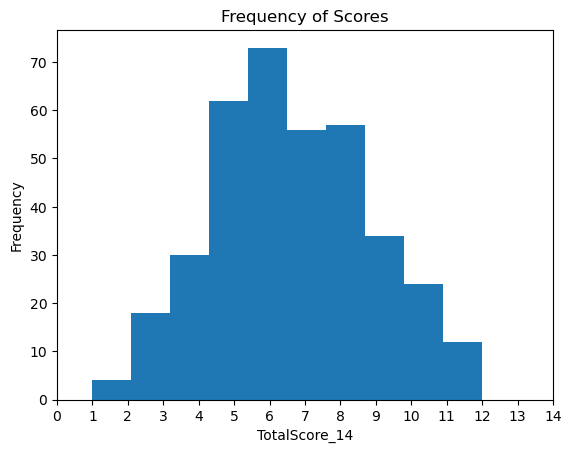

In [21]:
# The following graph represents frequency of each data point on "TotalScore_14" or the total score out of 19 questions across the sample.

df2['TotalScore_14'].plot(kind = 'hist', xticks = np.arange(0, 15, step=1), xlabel = 'TotalScore_14', title = 'Frequency of Scores' )

<Axes: title={'center': 'Absolute mean of scores for above data set'}>

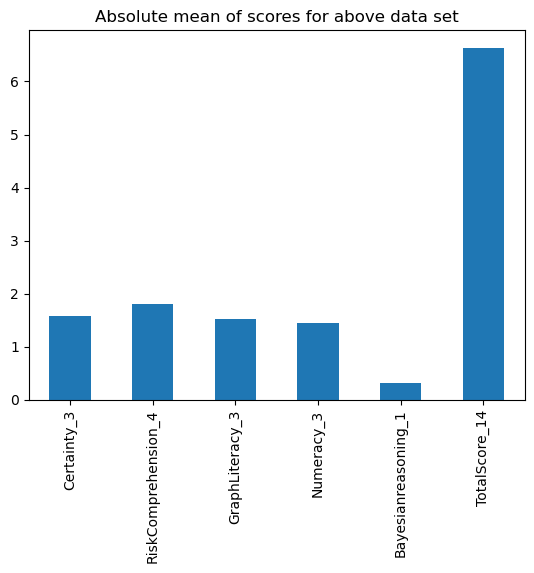

In [22]:
# Absolute mean scores for each facet

(df2[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0)).plot(kind = 'bar', title = 'Absolute mean of scores for above data set')

<Axes: title={'center': '% Mean of scores for above data set'}>

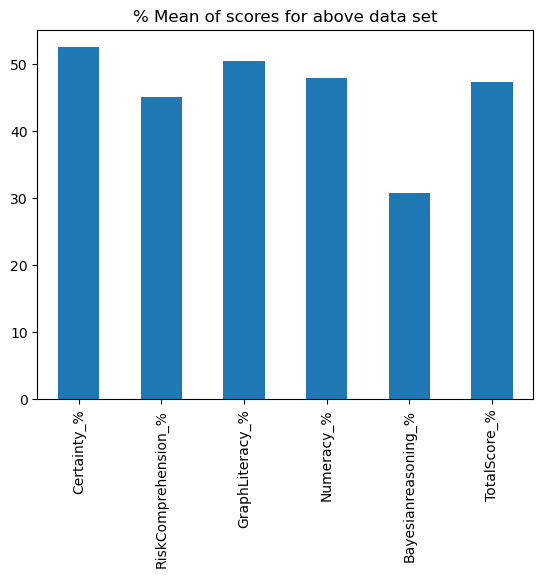

In [23]:
# Normalised mean scores for each facet

df2[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0).plot(kind = 'bar', title = '% Mean of scores for above data set')

In [24]:
# DF3 = Sorted by income

df3 = df2.sort_values(by = 'income')
df3 = df3.reset_index(drop = True)
df3.drop(df3[df3['income'] == 7].index, inplace = True)

df3

ResponseId  age  age_rec  isced  income      wealth  Certainty_3  \
0    R_1YkMM2lMB9aEuVL   41        3      2       1     25000.0            2   
1    R_4TuAjTfgjSCm6mA   29        2      2       1   5000000.0            0   
2    R_4U1OQvPwcT66nIZ   31        2      2       1   3000000.0            1   
3    R_4UEtElZbFSSlXJ7   21        2      1       1    100000.0            2   
4    R_4UhYEPTA8MuBMxr   23        2      2       1  20000000.0            1   
..                 ...  ...      ...    ...     ...         ...          ...   
365  R_4gkipJeAyfFWtDH   59        4      1       5  10000000.0            1   
366  R_48SQkLXmsHzNHIf   25        2      2       5       100.0            2   
367  R_4aQfSYuVQoXAOIh   30        2      3       5     50000.0            2   
368  R_4dh2UahPcKFLAYL   28        2      1       5    100000.0            3   
369  R_4rGgRh3Y7Grn2f5   20        2      2       5    500000.0            2   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      1                1           2                    0   
1                      0                3           2                    0   
2                      3                3           1                    0   
3                      2                3           2                    0   
4                      1                2           2                    0   
..                   ...              ...         ...                  ...   
365                    2                1           2                    0   
366                    1                1           2                    0   
367                    1                1           2                    0   
368                    1                0           2                    0   
369                    0                0           1                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0      66.666667                 25.0        33.333333   66.666667   
1       0.000000                  0.0       100.000000   66.666667   
2      33.333333                 75.0       100.000000   33.333333   
3      66.666667                 50.0       100.000000   66.666667   
4      33.333333                 25.0        66.666667   66.666667   
..           ...                  ...              ...         ...   
365    33.333333                 50.0        33.333333   66.666667   
366    66.666667                 25.0        33.333333   66.666667   
367    66.666667                 25.0        33.333333   66.666667   
368   100.000000                 25.0         0.000000   66.666667   
369    66.666667                  0.0         0.000000   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  
0                    0.0              6     42.857143  
1                    0.0              5     35.714286  
2                    0.0              8     57.142857  
3                    0.0              9     64.285714  
4                    0.0              6     42.857143  
..                   ...            ...           ...  
365                  0.0              6     42.857143  
366                  0.0              6     42.857143  
367                  0.0              6     42.857143  
368                  0.0              6     42.857143  
369                  0.0              3     21.428571  

[370 rows x 18 columns]

<Axes: title={'center': 'Absolute mean score for each facet'}>

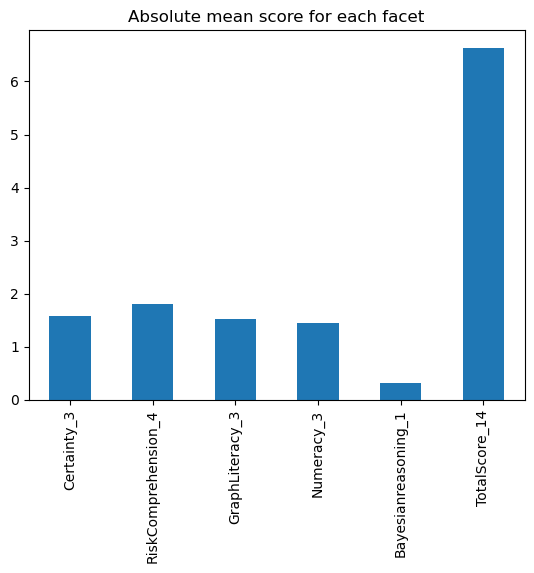

In [25]:
# Absolute mean score for each facet (Sort by Income)

df3[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0).plot(kind = 'bar', title = 'Absolute mean score for each facet')

<Axes: title={'center': '% Mean score for each facet'}>

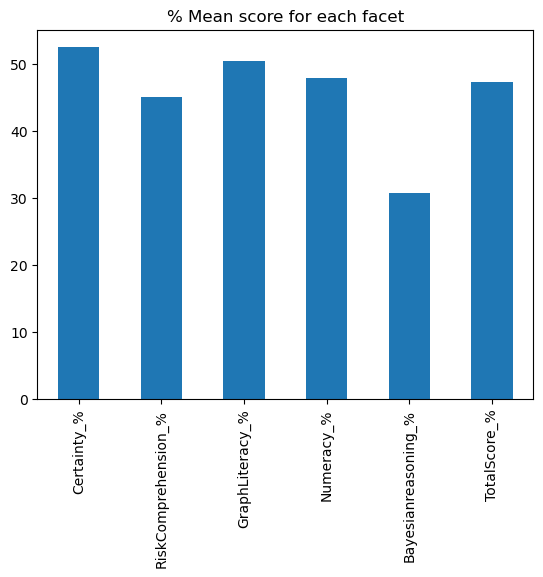

In [26]:
# Normalised mean score for each facet (Sort by Income)

(df3[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0)).plot(kind = 'bar', title = '% Mean score for each facet')

In [27]:
# Normalised mean of each facet as a numerical (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean()

Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
income                                                                  
1         56.281407            46.231156        52.931323   48.073702   
2         47.798742            47.641509        51.257862   47.169811   
3         45.714286            35.714286        48.571429   49.523810   
4         48.888889            46.666667        42.222222   44.444444   
5         55.555556            31.666667        24.444444   51.111111   

        Bayesianreasoning_%  TotalScore_%  
income                                     
1                 29.145729     48.994975  
2                 30.188679     47.102426  
3                 45.714286     44.285714  
4                 40.000000     45.238095  
5                 13.333333     38.095238

In [28]:
# Count of responses for each category (sorted by income)

df3.groupby('income')[['ResponseId']].count()

ResponseId
income            
1              199
2              106
3               35
4               15
5               15

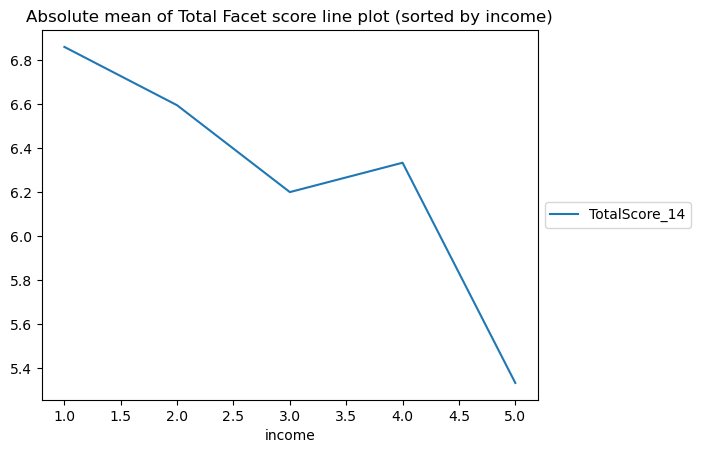

In [29]:
# Absolute mean of Total Facet score line plot (sorted by income)

df3.groupby('income')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute mean of Total Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

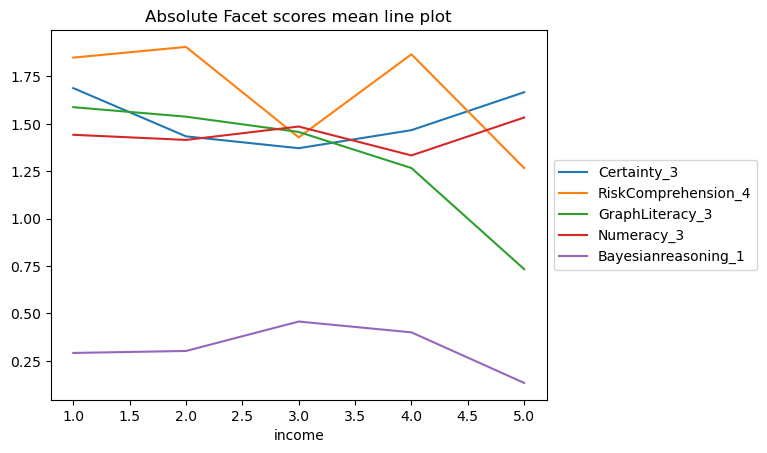

In [30]:
# Absolute mean of each Facet score line plot (sorted by income)

df3.groupby('income')[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

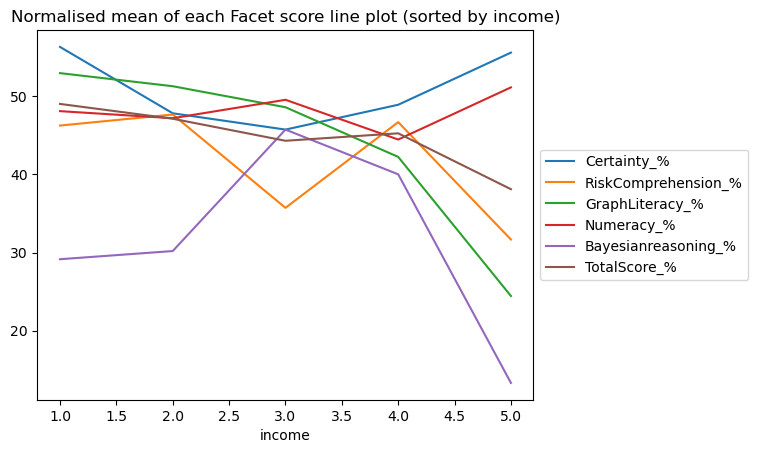

In [31]:
# Normalised mean of each Facet score line plot (sorted by income)


df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%', 'TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised mean of each Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

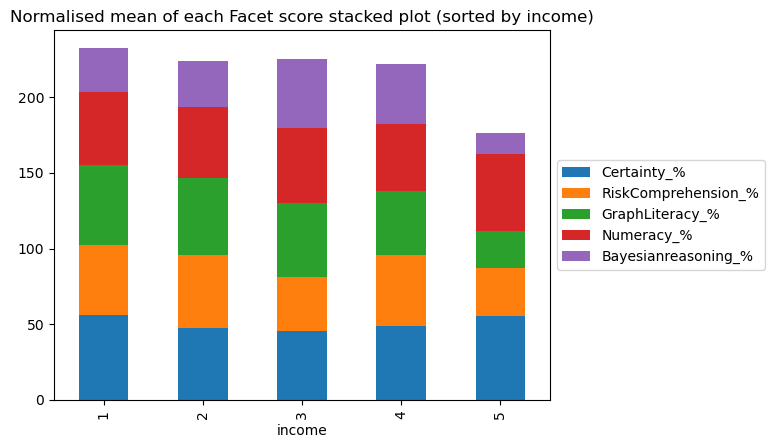

In [32]:
# Normalised mean of each Facet score stacked plot (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean of each Facet score stacked plot (sorted by income)', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

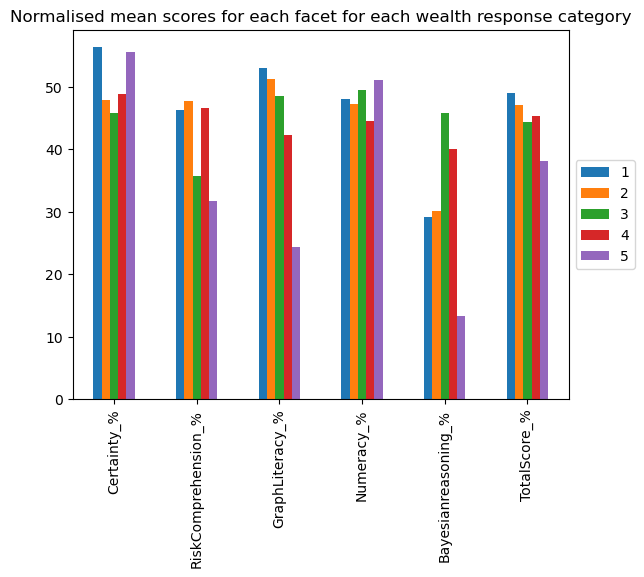

In [33]:
# Normalised mean of each Facet score hist plot (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='income', ylabel='TotalScore_14'>

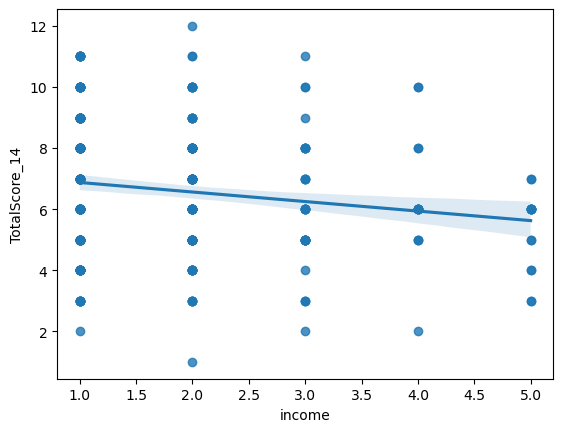

In [34]:
# Trend line for Absolute Total Facet Score vs income

sns.regplot (data = df3, x = 'income', y = 'TotalScore_14')

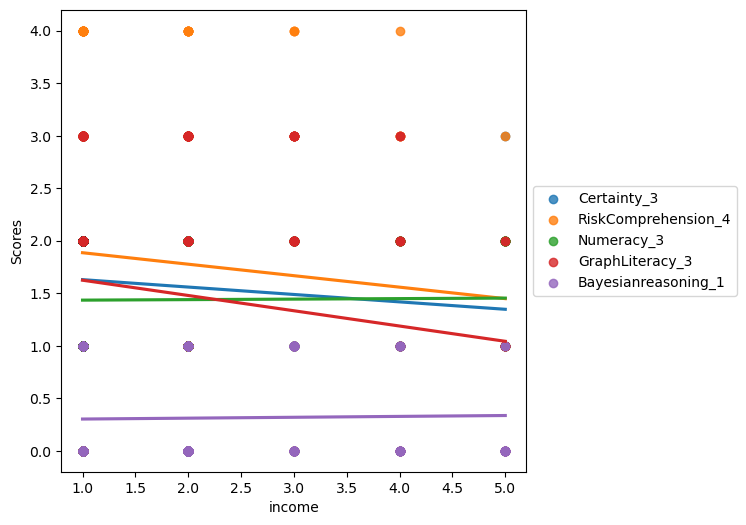

In [35]:
# Trend line for Absolute Independent Facet Score vs income reponses

fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot (data = df3, x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax, label='Certainty_3')
sns.regplot (data = df3, x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax, label='RiskComprehension_4')
sns.regplot (data = df3, x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax, label='Numeracy_3')
sns.regplot (data = df3, x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax, label='GraphLiteracy_3')
sns.regplot (data = df3, x = 'income', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax, label='Bayesianreasoning_1' )

ax.set(ylabel='Scores', xlabel='income')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='income', ylabel='TotalScore_14'>

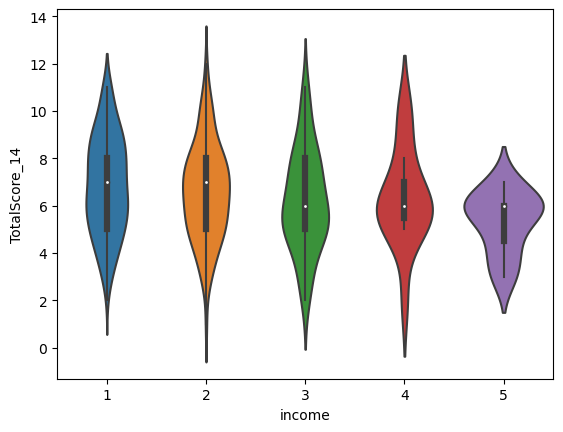

In [36]:
# Violine Plot for TotalScore_14 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'TotalScore_14')

<Axes: xlabel='income', ylabel='Certainty_3'>

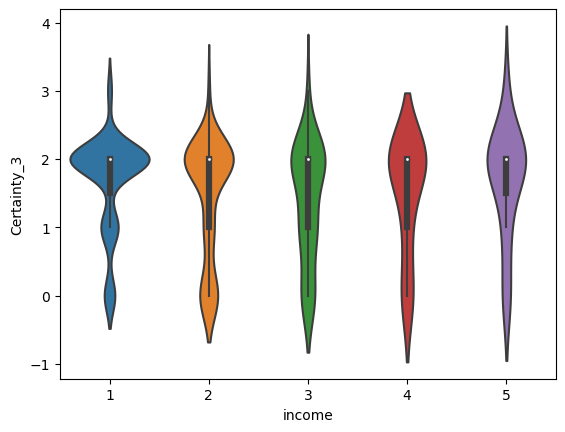

In [37]:
# Violine Plot for Certainty_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Certainty_3')

<Axes: xlabel='income', ylabel='RiskComprehension_4'>

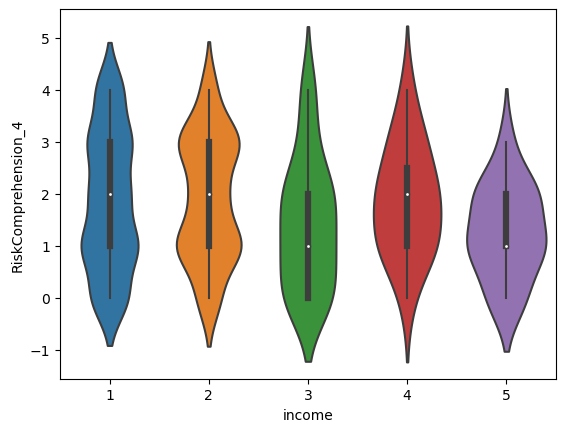

In [38]:
# Violine Plot for RiskComprehension_4 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'RiskComprehension_4')

<Axes: xlabel='income', ylabel='GraphLiteracy_3'>

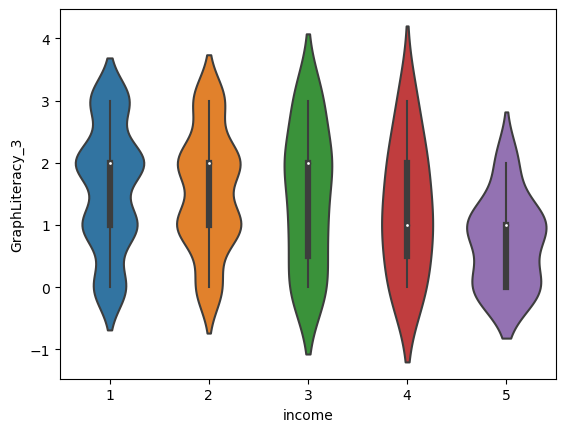

In [39]:
# Violine Plot for GraphLiteracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'GraphLiteracy_3')

<Axes: xlabel='income', ylabel='Numeracy_3'>

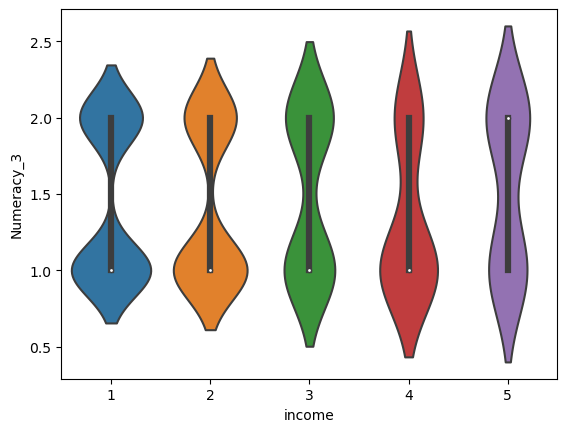

In [40]:
# Violine Plot for Numeracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Numeracy_3')

<Axes: xlabel='income', ylabel='Bayesianreasoning_1'>

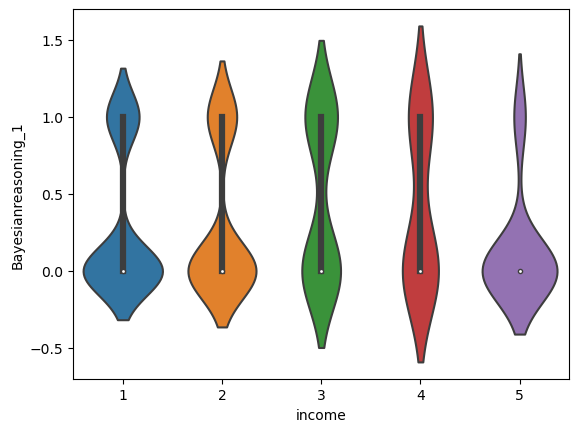

In [41]:
# Violine Plot for TotalScore_14 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Bayesianreasoning_1')

In [42]:
# Data Frame 2 or df2 is an aggregate data on facet total scores and over all total score, along with wealth and income data vs each response. 
# This data set is also sorted by wealth with all responses 'NA' removed.
# We also assign quartiles ranking each response according to this sort.

df4 = df2.sort_values(by = 'wealth')
df4 = df4.reset_index(drop = True)
df4 = df4.dropna(axis = 0, subset = 'wealth')
df4.insert(loc = len(df4.columns), column = "Quartile Number", value = pd.qcut(df4["wealth"],q = 4, labels = False ) + 1, allow_duplicates = 'False')

df4

ResponseId  age  age_rec  isced  income       wealth  Certainty_3  \
0    R_4DPGUOAP86yO30R   19        2      3       1          0.0            2   
1    R_4lnmGavSf6rw1eE   31        2      1       1          0.0            0   
2    R_4MJAzsNYYA69Y8p   27        2      3       1          0.0            2   
3    R_4fNO2Z5GF8KerZI   24        2      2       2          0.0            3   
4    R_41bfnamM0zpH94i   30        2      1       2          0.0            2   
..                 ...  ...      ...    ...     ...          ...          ...   
365  R_4M4Yd7LGKym7BaF   32        2      1       3  100000000.0            2   
366  R_4XgkSFVYD7YAAsS   18        2      2       3  100000000.0            1   
367  R_4FZL5zwyR3HMcyl   20        2      3       2  100000000.0            2   
368  R_4f2KZvIaLdZvVqN   27        2      2       5  120000000.0            2   
369  R_4kHu85k7anbQck8   25        2      2       2  150000000.0            0   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      2                2           1                    0   
1                      3                1           1                    0   
2                      1                1           2                    1   
3                      3                1           2                    1   
4                      2                1           1                    1   
..                   ...              ...         ...                  ...   
365                    1                3           2                    0   
366                    1                1           2                    0   
367                    2                2           1                    0   
368                    2                2           1                    0   
369                    3                1           1                    1   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0      66.666667                 50.0        66.666667   33.333333   
1       0.000000                 75.0        33.333333   33.333333   
2      66.666667                 25.0        33.333333   66.666667   
3     100.000000                 75.0        33.333333   66.666667   
4      66.666667                 50.0        33.333333   33.333333   
..           ...                  ...              ...         ...   
365    66.666667                 25.0       100.000000   66.666667   
366    33.333333                 25.0        33.333333   66.666667   
367    66.666667                 50.0        66.666667   33.333333   
368    66.666667                 50.0        66.666667   33.333333   
369     0.000000                 75.0        33.333333   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
0                    0.0              7     50.000000                1  
1                    0.0              5     35.714286                1  
2                  100.0              7     50.000000                1  
3                  100.0             10     71.428571                1  
4                  100.0              7     50.000000                1  
..                   ...            ...           ...              ...  
365                  0.0              8     57.142857                4  
366                  0.0              5     35.714286                4  
367                  0.0              7     50.000000                4  
368                  0.0              7     50.000000                4  
369                100.0              6     42.857143                4  

[370 rows x 19 columns]

<Axes: title={'center': 'Absolute mean score for each facet (Sort by Wealth)'}>

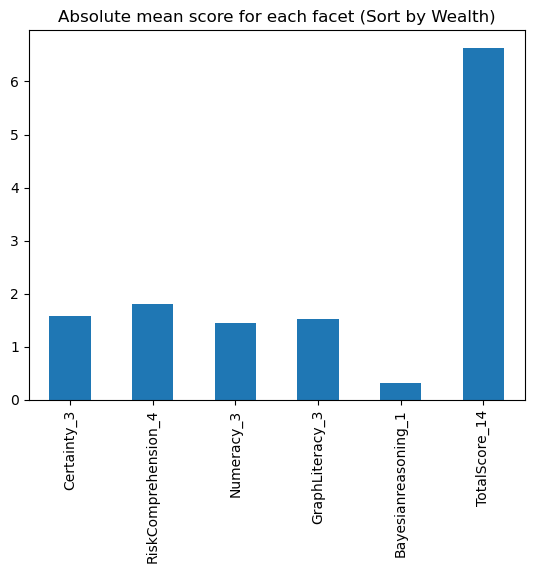

In [43]:
# Absolute mean score for each facet (Sort by Wealth)

df4[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0).plot(kind = 'bar', title = 'Absolute mean score for each facet (Sort by Wealth)')

<Axes: title={'center': 'Normalised mean score for each facet (Sort by Wealth)'}>

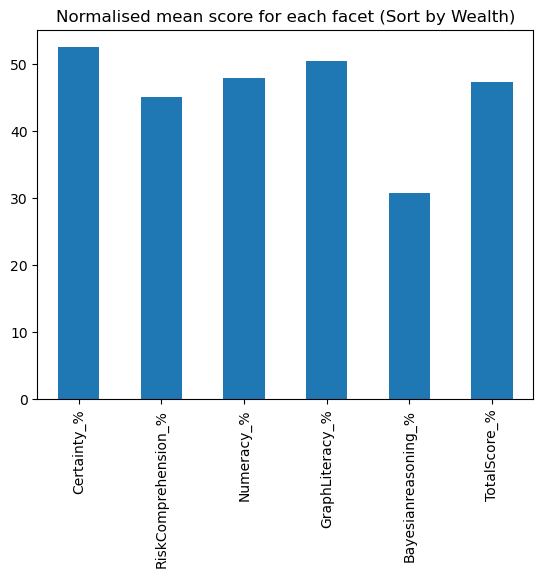

In [44]:
# Normalised mean score for each facet (Sort by Wealth)

(df4[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0)).plot(kind = 'bar', title = 'Normalised mean score for each facet (Sort by Wealth)')

<Axes: title={'center': 'Total responses line plot sorted by Wealth'}, xlabel='Unique responses sorted by wealth', ylabel='TotalScore_14'>

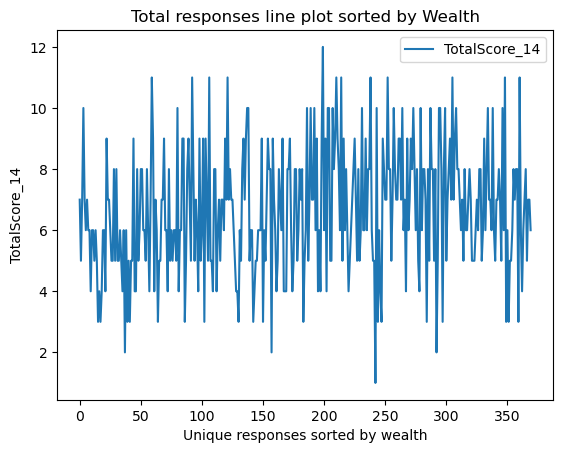

In [45]:
# Line Plot of Absolute Total Facet score vs sorted wealth

df4.plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total responses line plot sorted by Wealth',xlabel = 'Unique responses sorted by wealth', ylabel = 'TotalScore_14')

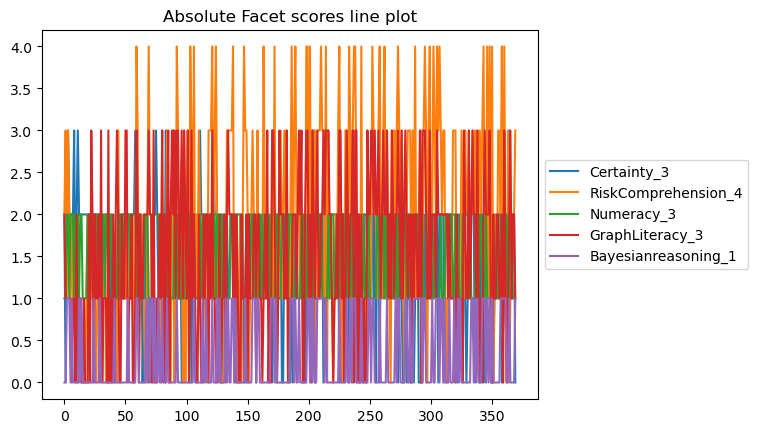

In [46]:
# Absolute Facet scores line plot from low to high wealth 
# I do understand that this is non readable

df4[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].plot( kind = 'line', title = 'Absolute Facet scores line plot', use_index = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: ylabel='TotalScore_14'>

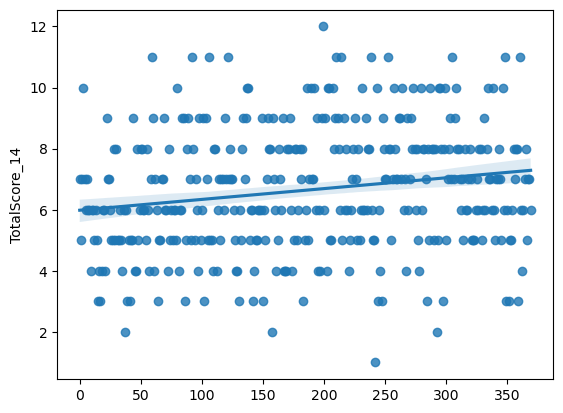

In [47]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses

sns.regplot (data = df4, x = df4.index, y = 'TotalScore_14')

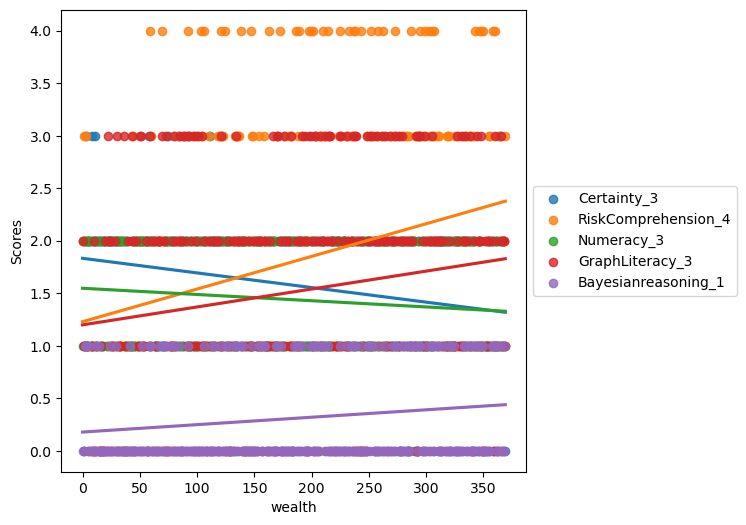

In [48]:
# Trend line for Absolute Independent Facet Score vs wealth reponses

fig1, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = df4.index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax1, label='Certainty_3')
sns.regplot (data = df4, x = df4.index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax1, label='RiskComprehension_4')
sns.regplot (data = df4, x = df4.index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax1, label='Numeracy_3')
sns.regplot (data = df4, x = df4.index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax1, label='GraphLiteracy_3')
sns.regplot (data = df4, x = df4.index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax1, label='Bayesianreasoning_1' )

ax1.set(ylabel='Scores', xlabel='wealth')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [49]:
# Count of number of responses under each quartile

df4.groupby('Quartile Number')[['Quartile Number']].count()

Quartile Number
Quartile Number                 
1                             97
2                             91
3                             96
4                             86

In [50]:
df4.loc[df4['Quartile Number']==1]

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
0   R_4DPGUOAP86yO30R   19        2      3       1       0.0            2   
1   R_4lnmGavSf6rw1eE   31        2      1       1       0.0            0   
2   R_4MJAzsNYYA69Y8p   27        2      3       1       0.0            2   
3   R_4fNO2Z5GF8KerZI   24        2      2       2       0.0            3   
4   R_41bfnamM0zpH94i   30        2      1       2       0.0            2   
..                ...  ...      ...    ...     ...       ...          ...   
92  R_49sPXSg2MnDTzkR   21        2      2       1  100000.0            1   
93  R_49ucUf021OosPGQ   35        2      1       1  100000.0            1   
94  R_4A9Iv5lYYQeK969   36        3      1       2  100000.0            2   
95  R_4CsvgqFBLfzgRSL   43        3      1       1  100000.0            2   
96  R_4CCuDlH0lEcMARo   23        2      2       1  100000.0            0   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                     2                2           1                    0   
1                     3                1           1                    0   
2                     1                1           2                    1   
3                     3                1           2                    1   
4                     2                1           1                    1   
..                  ...              ...         ...                  ...   
92                    4                3           2                    1   
93                    3                3           1                    0   
94                    1                1           1                    0   
95                    2                2           1                    0   
96                    2                3           1                    0   

    Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0     66.666667                 50.0        66.666667   33.333333   
1      0.000000                 75.0        33.333333   33.333333   
2     66.666667                 25.0        33.333333   66.666667   
3    100.000000                 75.0        33.333333   66.666667   
4     66.666667                 50.0        33.333333   33.333333   
..          ...                  ...              ...         ...   
92    33.333333                100.0       100.000000   66.666667   
93    33.333333                 75.0       100.000000   33.333333   
94    66.666667                 25.0        33.333333   33.333333   
95    66.666667                 50.0        66.666667   33.333333   
96     0.000000                 50.0       100.000000   33.333333   

    Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
0                   0.0              7     50.000000                1  
1                   0.0              5     35.714286                1  
2                 100.0              7     50.000000                1  
3                 100.0             10     71.428571                1  
4                 100.0              7     50.000000                1  
..                  ...            ...           ...              ...  
92                100.0             11     78.571429                1  
93                  0.0              8     57.142857                1  
94                  0.0              5     35.714286                1  
95                  0.0              7     50.000000                1  
96                  0.0              6     42.857143                1  

[97 rows x 19 columns]

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q1'}, xlabel='Unique responses', ylabel='TotalScore_14'>

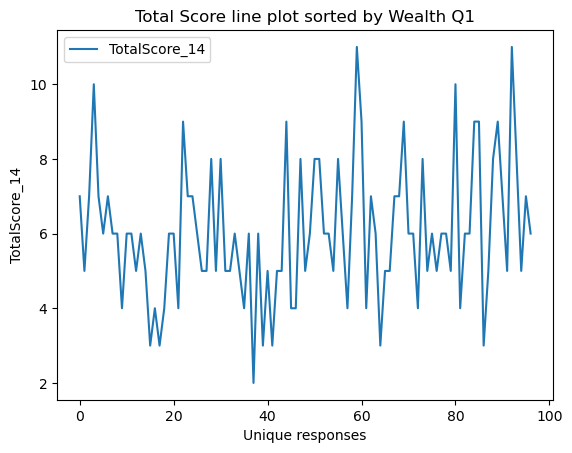

In [51]:
# This graph is basically a line plot of the TotalScore_14 across first quartile unique responses which are ordered by income

df4.loc[df4['Quartile Number']==1].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q1',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

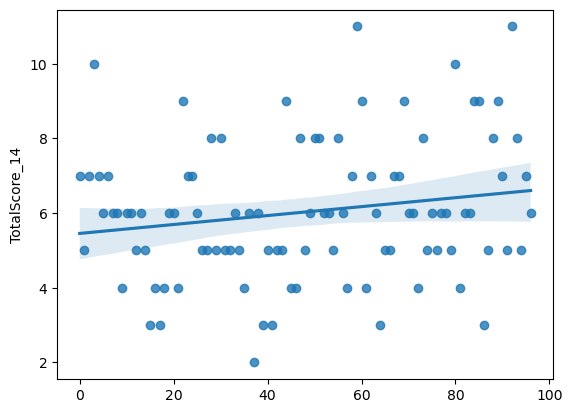

In [52]:
# Trend line for Absolute Total Facet Score vs unique Q14. Income reponses in Quartile 1

sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'TotalScore_14')

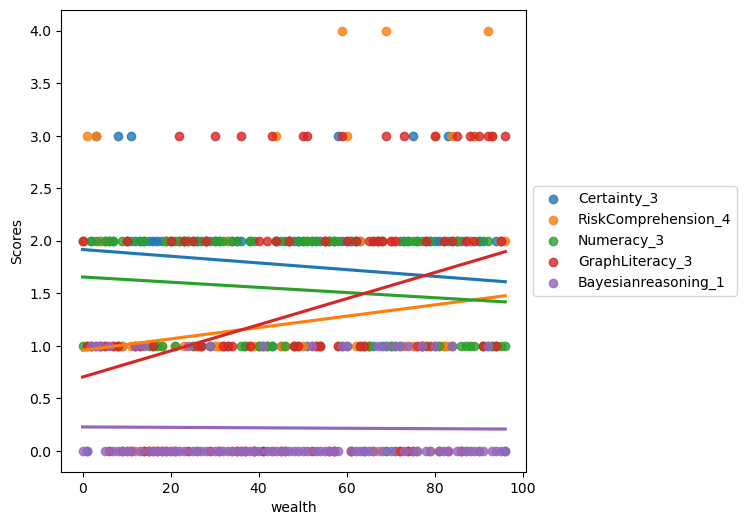

In [53]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 1

fig1, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax2, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax2, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [54]:
df4.loc[df4['Quartile Number']==2]

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
97   R_4s4QJ9m9ViKLDPf   19        2      3       1  101000.0            1   
98   R_4qh6umVAgcFqF0h   22        2      2       1  112378.0            2   
99   R_4kN4Jn7Y8hHdzlY   23        2      2       1  120000.0            2   
100  R_437fyX4DcVGhqJe   40        3      1       2  150000.0            2   
101  R_4PFudUMcC09ZJk8   36        3      2       2  150000.0            2   
..                 ...  ...      ...    ...     ...       ...          ...   
183  R_4rGgRh3Y7Grn2f5   20        2      2       5  500000.0            2   
184  R_40VyTmJ6i96wUP4   34        2      1       1  500000.0            2   
185  R_4eUXMOw0QY7ovqu   24        2      2       3  500000.0            0   
186  R_4C2WItrJsoTF1cE   19        2      2       1  500000.0            2   
187  R_4wdhk4DDjmecH1A   29        2      2       2  500000.0            0   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
97                     0                1           2                    0   
98                     3                3           1                    0   
99                     0                2           1                    0   
100                    2                1           1                    0   
101                    3                3           1                    0   
..                   ...              ...         ...                  ...   
183                    0                0           1                    0   
184                    0                1           2                    0   
185                    2                1           2                    1   
186                    4                1           2                    1   
187                    1                2           1                    1   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
97     33.333333                  0.0        33.333333   66.666667   
98     66.666667                 75.0       100.000000   33.333333   
99     66.666667                  0.0        66.666667   33.333333   
100    66.666667                 50.0        33.333333   33.333333   
101    66.666667                 75.0       100.000000   33.333333   
..           ...                  ...              ...         ...   
183    66.666667                  0.0         0.000000   33.333333   
184    66.666667                  0.0        33.333333   66.666667   
185     0.000000                 50.0        33.333333   66.666667   
186    66.666667                100.0        33.333333   66.666667   
187     0.000000                 25.0        66.666667   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
97                   0.0              4     28.571429                2  
98                   0.0              9     64.285714                2  
99                   0.0              5     35.714286                2  
100                  0.0              6     42.857143                2  
101                  0.0              9     64.285714                2  
..                   ...            ...           ...              ...  
183                  0.0              3     21.428571                2  
184                  0.0              5     35.714286                2  
185                100.0              6     42.857143                2  
186                100.0             10     71.428571                2  
187                100.0              5     35.714286                2  

[91 rows x 19 columns]

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q1'}, xlabel='Unique responses', ylabel='TotalScore_14'>

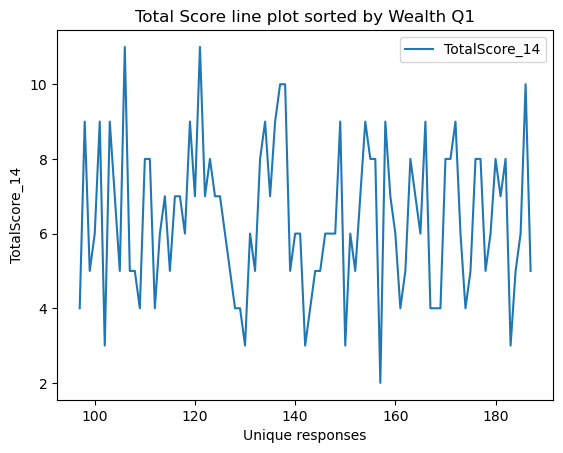

In [55]:
# This graph is basically a line plot of the TotalScore_14 across second quartile unique responses which are ordered by income

df4.loc[df4['Quartile Number']==2].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q1',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

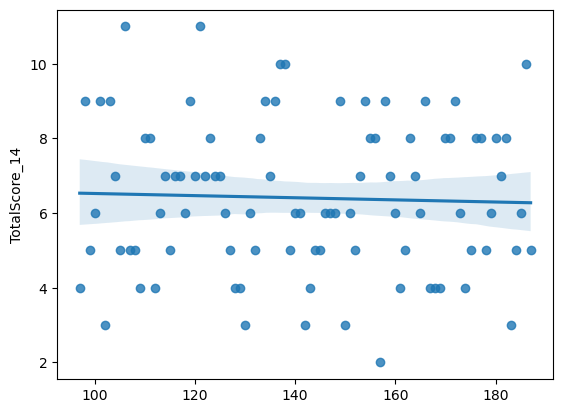

In [56]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 2

sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'TotalScore_14')

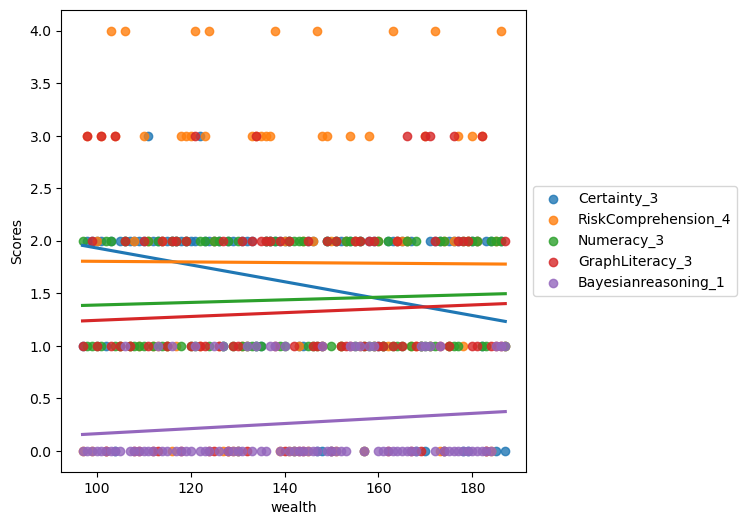

In [57]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 2

fig1, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax3, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax3, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax3, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax3, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax3, label='Bayesianreasoning_1' )

ax3.set(ylabel='Scores', xlabel='wealth')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [58]:
df4.loc[df4['Quartile Number']==3]

ResponseId  age  age_rec  isced  income     wealth  Certainty_3  \
188  R_4MbebluzsBWokIc   57        4      2       2   550000.0            1   
189  R_4TuHdn6ifelyTqF   42        3      2       2   600000.0            2   
190  R_4Issx8w7LuZg7Yt   28        2      2       2   600000.0            2   
191  R_4jTmQ2fyl4GIZKf   24        2      2       1   600000.0            2   
192  R_4EpvHZs1AkqudDX   24        2      2       1   600000.0            2   
..                 ...  ...      ...    ...     ...        ...          ...   
279  R_4IXCBojUC4PBdve   51        3      2       2  3000000.0            2   
280  R_4EcDVJCgRS2diGg   32        2      1       5  3000000.0            0   
281  R_41hdf8aceebqOfl   25        2      2       2  3000000.0            2   
282  R_4EneslabJXcCOT4   18        2      3       1  3000000.0            2   
283  R_4pPBZhFSJIbPPha   45        3      1       3  3000000.0            0   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
188                    3                2           1                    0   
189                    4                2           1                    1   
190                    2                1           2                    0   
191                    2                2           1                    0   
192                    3                3           1                    1   
..                   ...              ...         ...                  ...   
279                    2                3           2                    1   
280                    2                2           1                    1   
281                    3                1           2                    0   
282                    3                2           1                    0   
283                    3                2           1                    1   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
188    33.333333                 75.0        66.666667   33.333333   
189    66.666667                100.0        66.666667   33.333333   
190    66.666667                 50.0        33.333333   66.666667   
191    66.666667                 50.0        66.666667   33.333333   
192    66.666667                 75.0       100.000000   33.333333   
..           ...                  ...              ...         ...   
279    66.666667                 50.0       100.000000   66.666667   
280     0.000000                 50.0        66.666667   33.333333   
281    66.666667                 75.0        33.333333   66.666667   
282    66.666667                 75.0        66.666667   33.333333   
283     0.000000                 75.0        66.666667   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
188                  0.0              7     50.000000                3  
189                100.0             10     71.428571                3  
190                  0.0              7     50.000000                3  
191                  0.0              7     50.000000                3  
192                100.0             10     71.428571                3  
..                   ...            ...           ...              ...  
279                100.0             10     71.428571                3  
280                100.0              6     42.857143                3  
281                  0.0              8     57.142857                3  
282                  0.0              8     57.142857                3  
283                100.0              7     50.000000                3  

[96 rows x 19 columns]

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q3'}, xlabel='Unique responses', ylabel='TotalScore_14'>

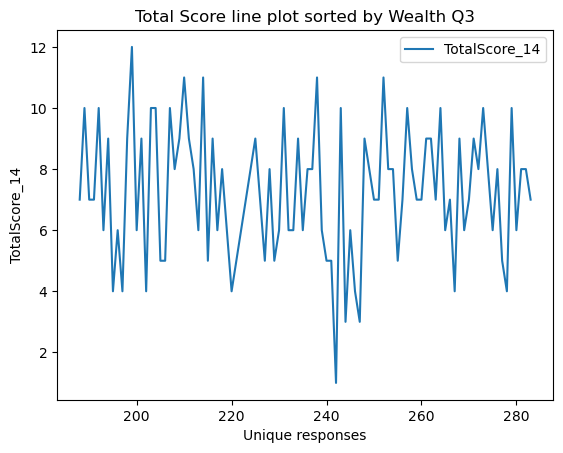

In [59]:
# This graph is basically a line plot of the TotalScore_14 across third quartile unique responses which are ordered by wealth

df4.loc[df4['Quartile Number']==3].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q3',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

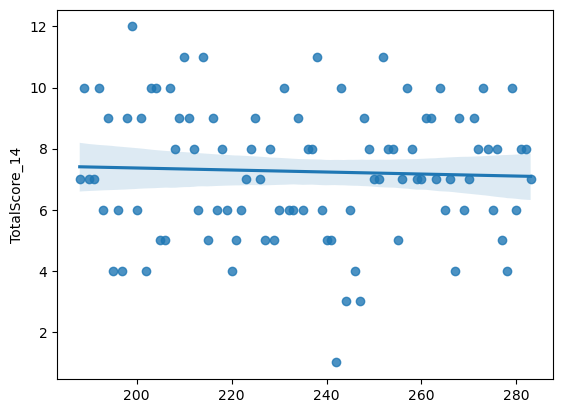

In [60]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 3

sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'TotalScore_14')

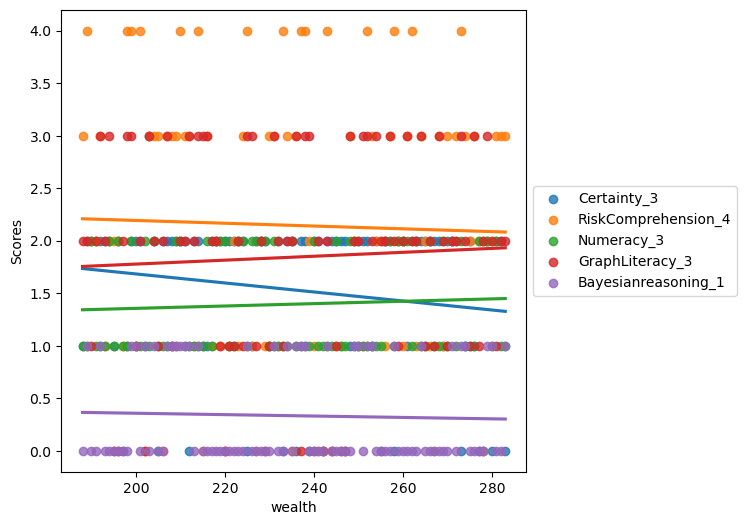

In [61]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 3

fig1, ax4 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax4, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax4, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax4, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax4, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax4, label='Bayesianreasoning_1' )

ax4.set(ylabel='Scores', xlabel='wealth')
ax4.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [62]:
df4.loc[df4['Quartile Number']==4]

ResponseId  age  age_rec  isced  income       wealth  Certainty_3  \
284  R_4FVQvDpbnyvqOQY   28        2      1       2    3200000.0            0   
285  R_4dyDxqwOf6c5bUt   46        3      1       2    4000000.0            2   
286  R_4w1ruZDnw0ZQRxf   22        2      3       4    4000000.0            0   
287  R_4Rft74IKSrfwItv   24        2      1       1    4000000.0            1   
288  R_4NERL55GtGXfKj7   40        3      2       1    4000000.0            2   
..                 ...  ...      ...    ...     ...          ...          ...   
365  R_4M4Yd7LGKym7BaF   32        2      1       3  100000000.0            2   
366  R_4XgkSFVYD7YAAsS   18        2      2       3  100000000.0            1   
367  R_4FZL5zwyR3HMcyl   20        2      3       2  100000000.0            2   
368  R_4f2KZvIaLdZvVqN   27        2      2       5  120000000.0            2   
369  R_4kHu85k7anbQck8   25        2      2       2  150000000.0            0   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
284                    1                0           2                    0   
285                    3                2           1                    0   
286                    1                1           2                    1   
287                    4                2           2                    1   
288                    1                2           2                    1   
..                   ...              ...         ...                  ...   
365                    1                3           2                    0   
366                    1                1           2                    0   
367                    2                2           1                    0   
368                    2                2           1                    0   
369                    3                1           1                    1   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
284     0.000000                 25.0         0.000000   66.666667   
285    66.666667                 75.0        66.666667   33.333333   
286     0.000000                 25.0        33.333333   66.666667   
287    33.333333                100.0        66.666667   66.666667   
288    66.666667                 25.0        66.666667   66.666667   
..           ...                  ...              ...         ...   
365    66.666667                 25.0       100.000000   66.666667   
366    33.333333                 25.0        33.333333   66.666667   
367    66.666667                 50.0        66.666667   33.333333   
368    66.666667                 50.0        66.666667   33.333333   
369     0.000000                 75.0        33.333333   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
284                  0.0              3     21.428571                4  
285                  0.0              8     57.142857                4  
286                100.0              5     35.714286                4  
287                100.0             10     71.428571                4  
288                100.0              8     57.142857                4  
..                   ...            ...           ...              ...  
365                  0.0              8     57.142857                4  
366                  0.0              5     35.714286                4  
367                  0.0              7     50.000000                4  
368                  0.0              7     50.000000                4  
369                100.0              6     42.857143                4  

[86 rows x 19 columns]

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q4'}, xlabel='Unique responses', ylabel='TotalScore_14'>

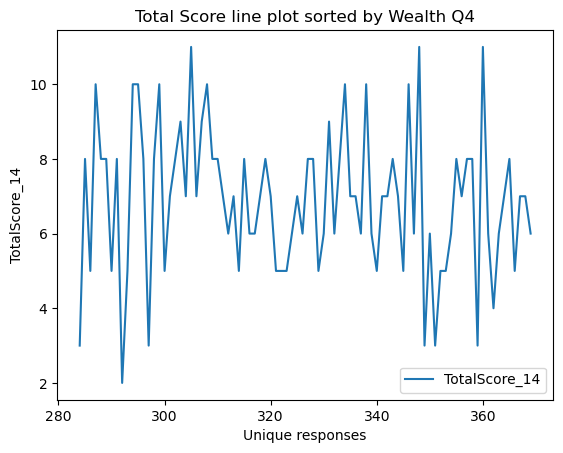

In [63]:
# This graph is basically a line plot of the TotalScore_14 across fourth quartile unique responses which are ordered by Wealth

df4.loc[df4['Quartile Number']==4].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q4',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

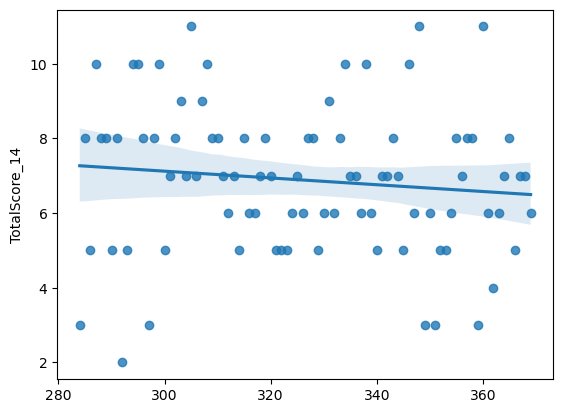

In [64]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 4

sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'TotalScore_14')

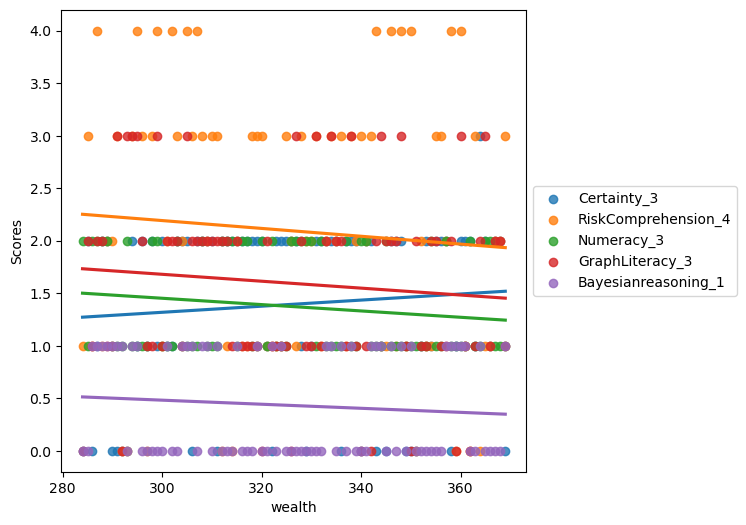

In [65]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 4

fig1, ax5 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax5, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax5, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax5, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax5, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax5, label='Bayesianreasoning_1' )

ax5.set(ylabel='Scores', xlabel='wealth')
ax5.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

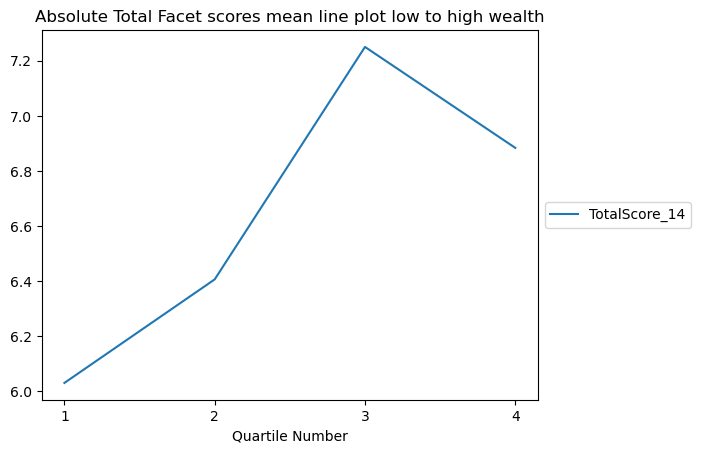

In [66]:
# Absolute Total Facet scores mean line plot from low to high Wealth

df4.groupby('Quartile Number')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

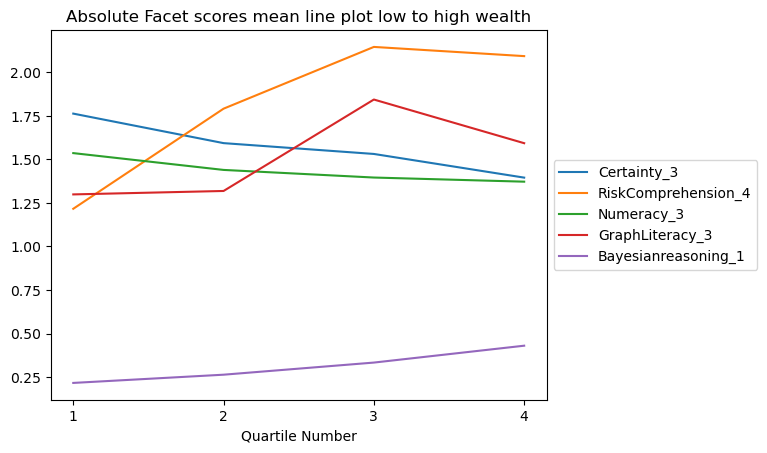

In [67]:
# Absolute Facet scores mean line plot from low to high wealth

df4.groupby('Quartile Number')[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

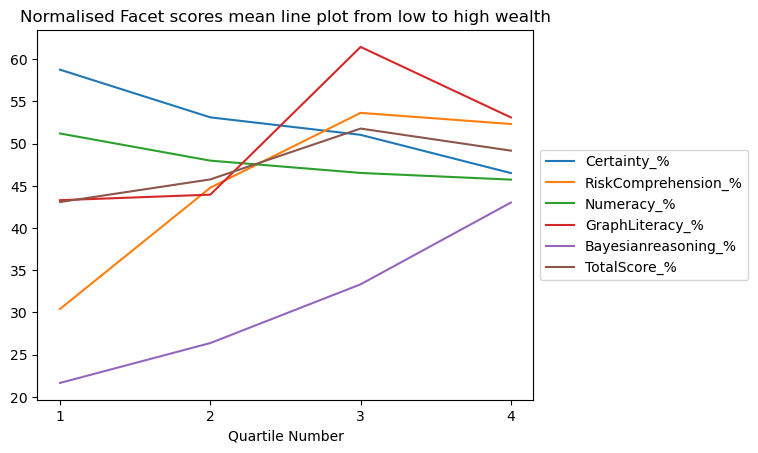

In [68]:
# Normalised Facet scores mean line plot from low to high wealth


df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot from low to high wealth',  xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

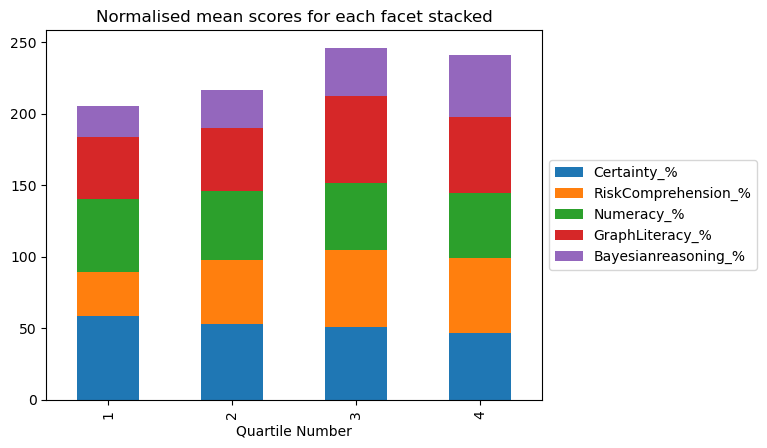

In [69]:
# Normalised mean scores for each facet stacked

df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

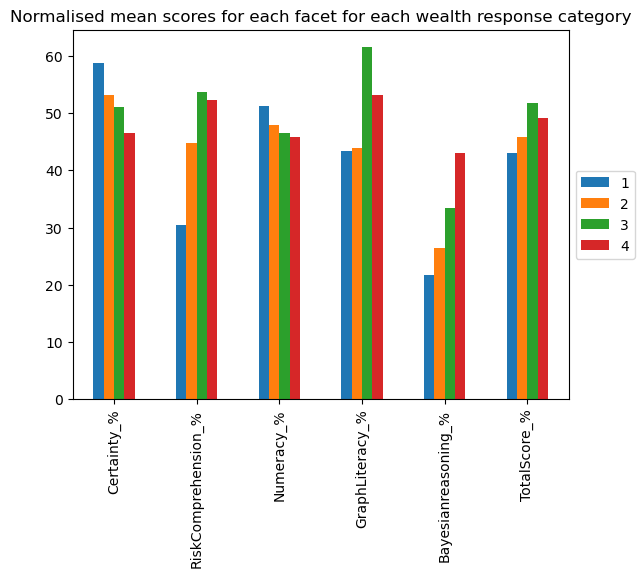

In [70]:
# Normalised mean scores for each facet for each wealth response Quartile

df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='Quartile Number', ylabel='TotalScore_14'>

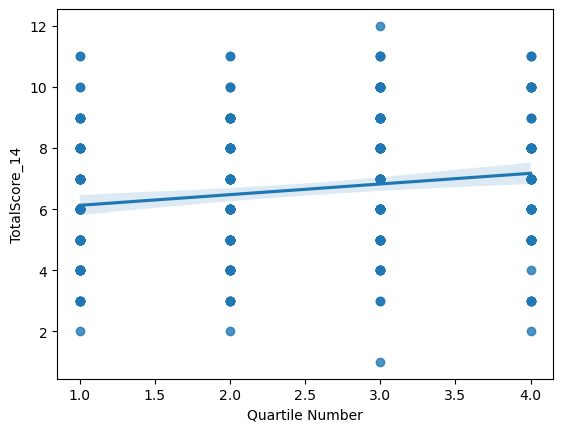

In [71]:
# Trend line for Absolute Total Facet Score vs Quartiles

sns.regplot (data = df4, x = 'Quartile Number', y = 'TotalScore_14')

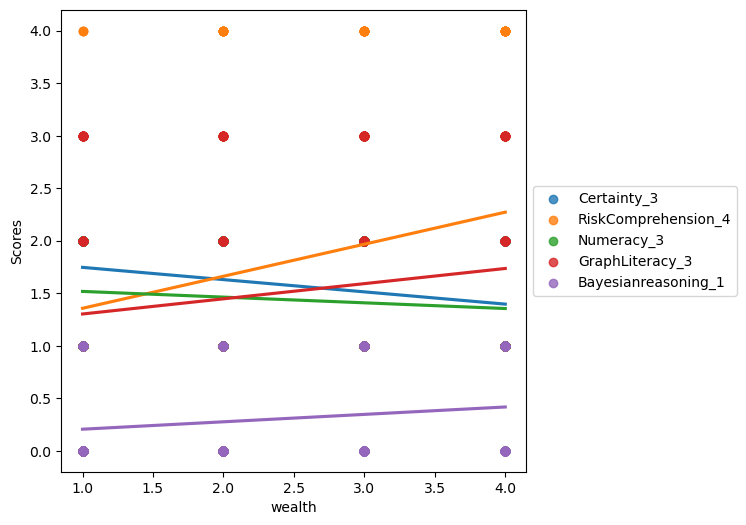

In [72]:
# Trend line for Absolute Independent Facet Score vs Quartiles

fig2, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = 'Quartile Number', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax2, label='Certainty_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_4')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax2, label='Numeracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='Quartile Number', ylabel='TotalScore_14'>

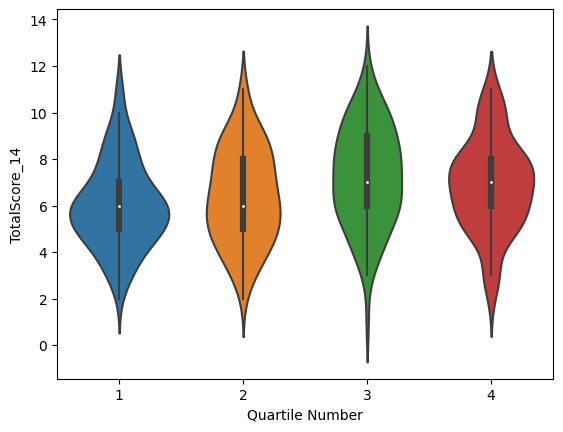

In [73]:
# Violine Plot for TotalScore_14 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'TotalScore_14')

<Axes: xlabel='Quartile Number', ylabel='Certainty_3'>

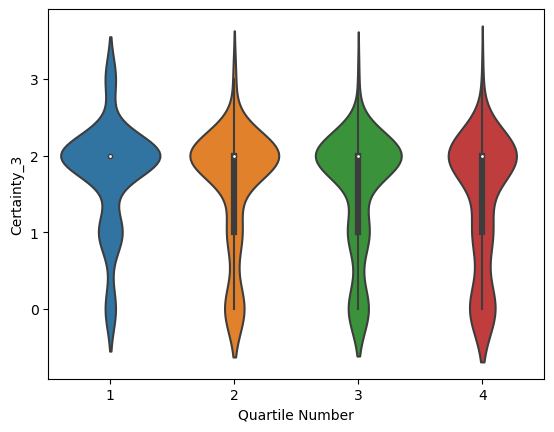

In [74]:
# Violine Plot for Certainty_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Certainty_3')

<Axes: xlabel='Quartile Number', ylabel='RiskComprehension_4'>

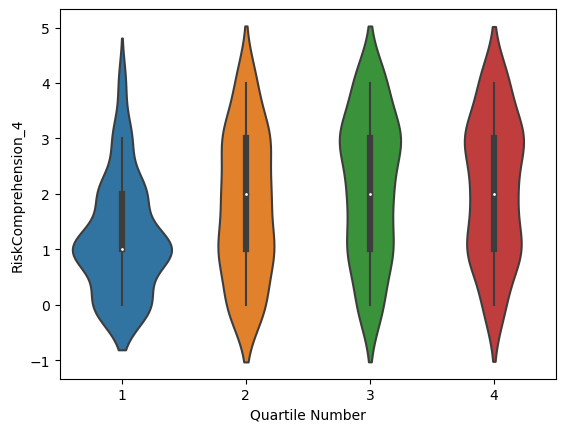

In [75]:
# Violine Plot for RiskComprehension_4 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'RiskComprehension_4')

<Axes: xlabel='Quartile Number', ylabel='GraphLiteracy_3'>

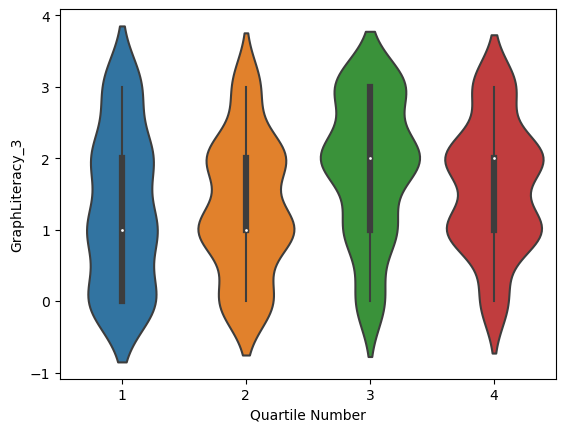

In [76]:
# Violine Plot for GraphLiteracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3')

<Axes: xlabel='Quartile Number', ylabel='Numeracy_3'>

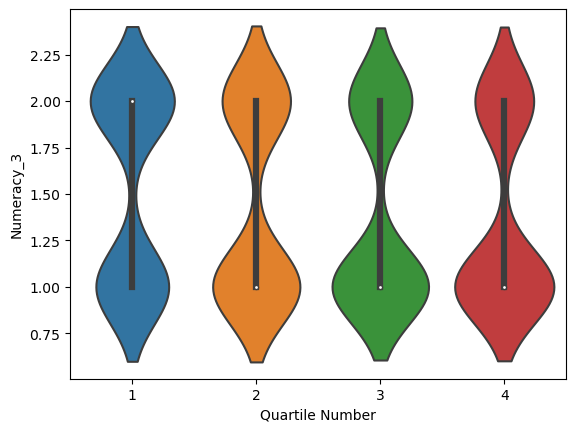

In [77]:
# Violine Plot for Numeracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Numeracy_3')

<Axes: xlabel='Quartile Number', ylabel='Bayesianreasoning_1'>

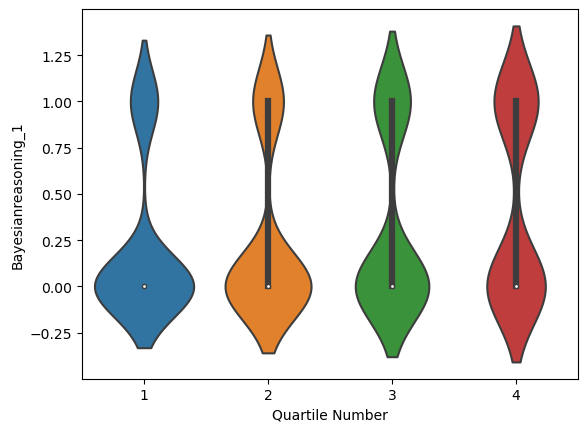

In [78]:
# Violine Plot for Bayesianreasoning_1 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1')

In [79]:
# Data Frame 5 or df5 is an aggregate data on facet total scores and over all total score, along with  education data vs each response. 
# This data set is now sorted by education.

df5 = df2.sort_values(by = 'isced')
df5 = df5.reset_index(drop = True)

df5

ResponseId  age  age_rec  isced  income      wealth  Certainty_3  \
0    R_4XhfVqNhg49zZXe   37        3      1       2   6000000.0            2   
1    R_4FjN0R9SXA0s0G5   53        3      1       2   5000000.0            2   
2    R_4Ph1UNtYnaoPSX7   25        2      1       3    400000.0            0   
3    R_4FVQvDpbnyvqOQY   28        2      1       2   3200000.0            0   
4    R_4PjnTbc2vIjogot   31        2      1       1    200000.0            2   
..                 ...  ...      ...    ...     ...         ...          ...   
365  R_4fkCPjfYl6UggHL   18        2      3       1   1000000.0            2   
366  R_4K6WL8dnMy7ODbs   18        2      3       5    100000.0            2   
367  R_4ANgmQQx8TBl3kc   21        2      3       1  16000000.0            0   
368  R_4MJAzsNYYA69Y8p   27        2      3       1         0.0            2   
369  R_4EneslabJXcCOT4   18        2      3       1   3000000.0            2   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      0                1           2                    0   
1                      2                1           1                    1   
2                      2                0           1                    0   
3                      1                0           2                    0   
4                      1                0           1                    0   
..                   ...              ...         ...                  ...   
365                    3                1           2                    1   
366                    0                1           2                    0   
367                    4                2           1                    1   
368                    1                1           2                    1   
369                    3                2           1                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0      66.666667                  0.0        33.333333   66.666667   
1      66.666667                 50.0        33.333333   33.333333   
2       0.000000                 50.0         0.000000   33.333333   
3       0.000000                 25.0         0.000000   66.666667   
4      66.666667                 25.0         0.000000   33.333333   
..           ...                  ...              ...         ...   
365    66.666667                 75.0        33.333333   66.666667   
366    66.666667                  0.0        33.333333   66.666667   
367     0.000000                100.0        66.666667   33.333333   
368    66.666667                 25.0        33.333333   66.666667   
369    66.666667                 75.0        66.666667   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  
0                    0.0              5     35.714286  
1                  100.0              7     50.000000  
2                    0.0              3     21.428571  
3                    0.0              3     21.428571  
4                    0.0              4     28.571429  
..                   ...            ...           ...  
365                100.0              9     64.285714  
366                  0.0              5     35.714286  
367                100.0              8     57.142857  
368                100.0              7     50.000000  
369                  0.0              8     57.142857  

[370 rows x 18 columns]

In [80]:
# since we didnt drop any values, the dataset is essentially the same as df2, but sorted

In [81]:
# Mean of each facet as a % for each category of isced

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean()

Certainty_%  RiskComprehension_%  Numeracy_%  GraphLiteracy_%  \
isced                                                                  
1        51.851852            44.444444   48.677249        49.470899   
2        51.741294            46.268657   47.097844        51.741294   
3        58.139535            41.279070   49.612403        47.286822   

       Bayesianreasoning_%  
isced                       
1                28.571429  
2                31.840796  
3                32.558140

In [82]:
# Count of responses for each category isced

df5.groupby('isced')[['ResponseId']].count()

ResponseId
isced            
1             126
2             201
3              43

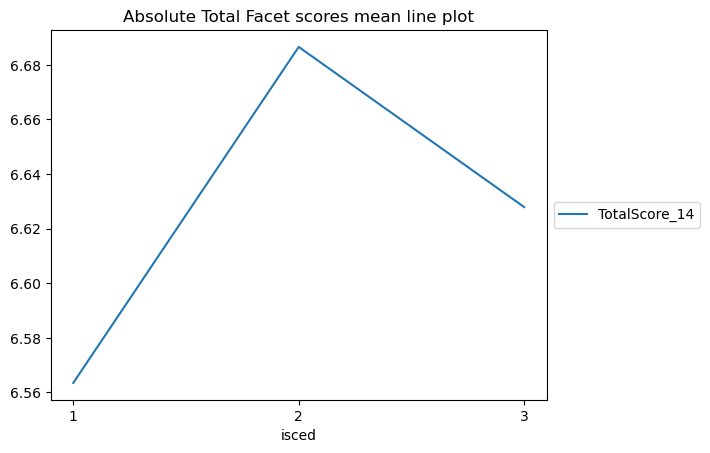

In [83]:
# Absolute Total Facet scores mean line plot from low to high education

df5.groupby('isced')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

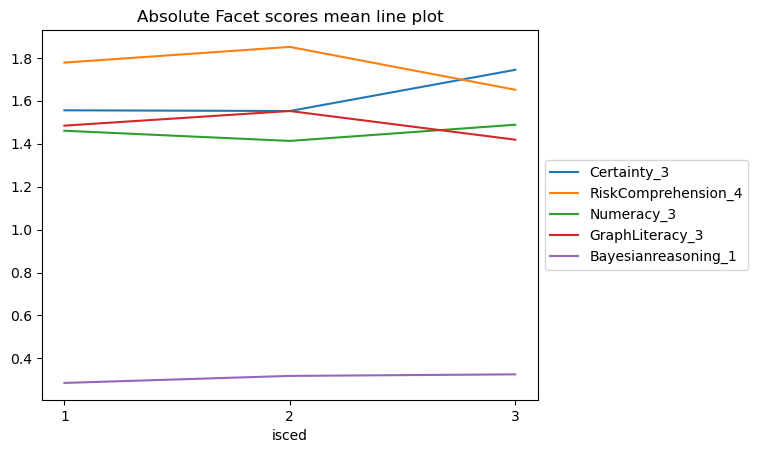

In [84]:
# Absolute Facet scores mean line plot from low to high edu

df5.groupby('isced')[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

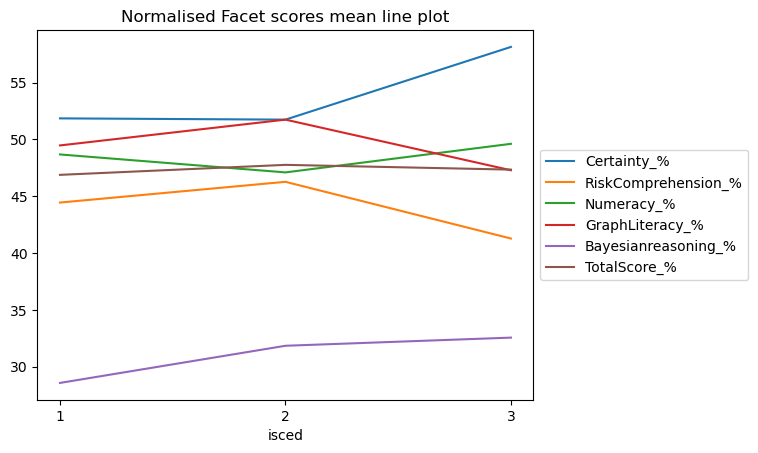

In [85]:
# Normalised Facet scores mean line plot from low to high edu


df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

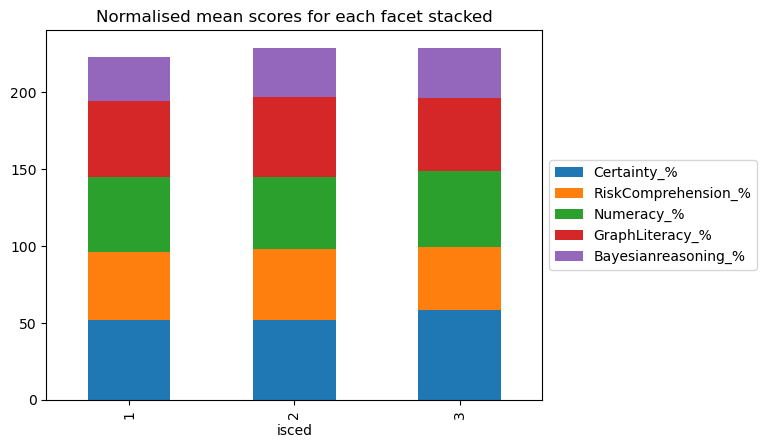

In [86]:
# Normalised mean scores for each facet stacked

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

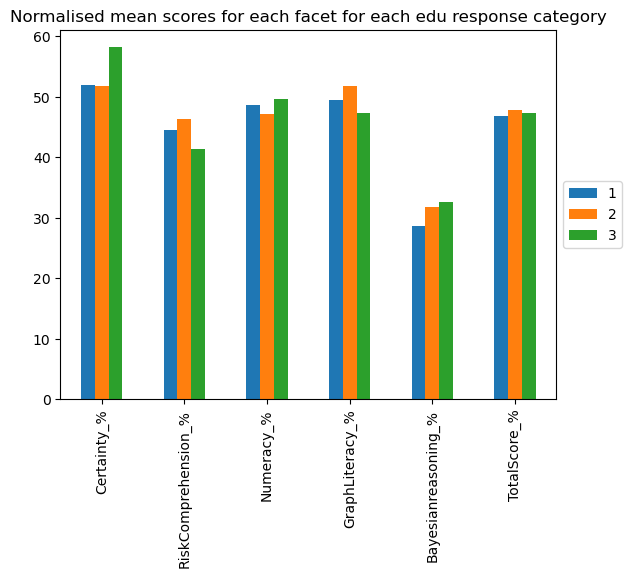

In [87]:
# Normalised mean scores for each facet for each edu response category

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each edu response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='isced', ylabel='TotalScore_14'>

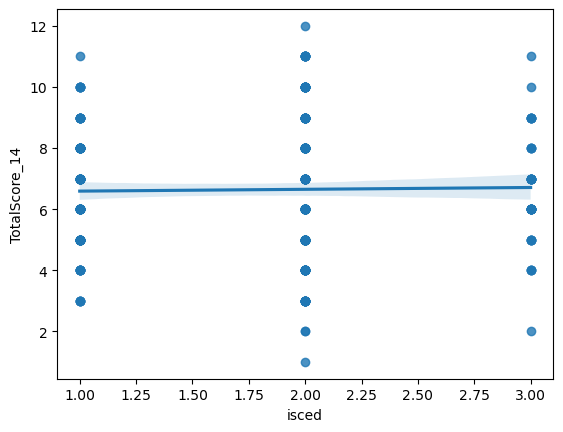

In [88]:
# Trend line for Absolute Total Facet Score vs edu (isced) reponses

sns.regplot (data = df5, x = 'isced', y = 'TotalScore_14')

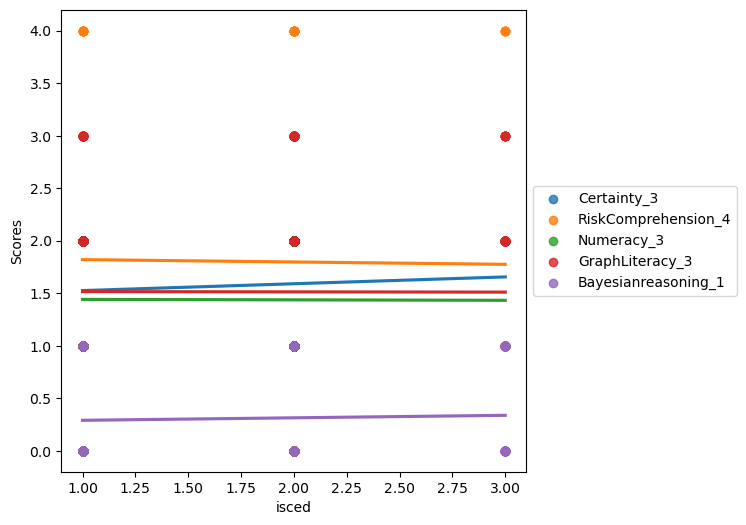

In [89]:
# Trend line for Absolute Independent Facet Score vs edu (isced) reponses

fig, ax6 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df5, x = 'isced', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax6, label='Certainty_3')
sns.regplot (data = df5, x = 'isced', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax6, label='RiskComprehension_4')
sns.regplot (data = df5, x = 'isced', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax6, label='Numeracy_3')
sns.regplot (data = df5, x = 'isced', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax6, label='GraphLiteracy_3')
sns.regplot (data = df5, x = 'isced', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax6, label='Bayesianreasoning_1' )

ax6.set(ylabel='Scores', xlabel='isced')
ax6.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='isced', ylabel='TotalScore_14'>

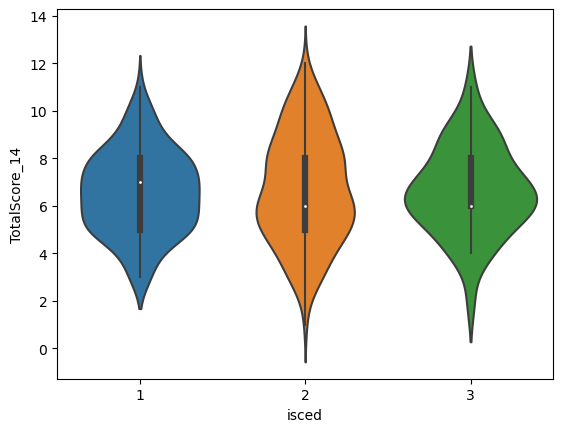

In [90]:
# Violine Plot for TotalScore_14 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'TotalScore_14')

<Axes: xlabel='isced', ylabel='Certainty_3'>

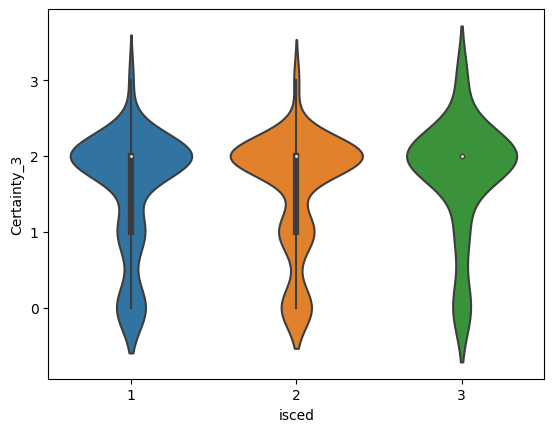

In [91]:
# Violine Plot for Certainty_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Certainty_3')

<Axes: xlabel='isced', ylabel='RiskComprehension_4'>

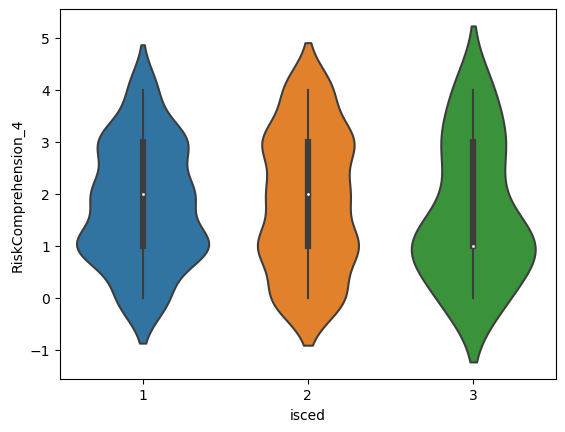

In [92]:
# Violine Plot for RiskComprehension_4 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'RiskComprehension_4')

<Axes: xlabel='isced', ylabel='GraphLiteracy_3'>

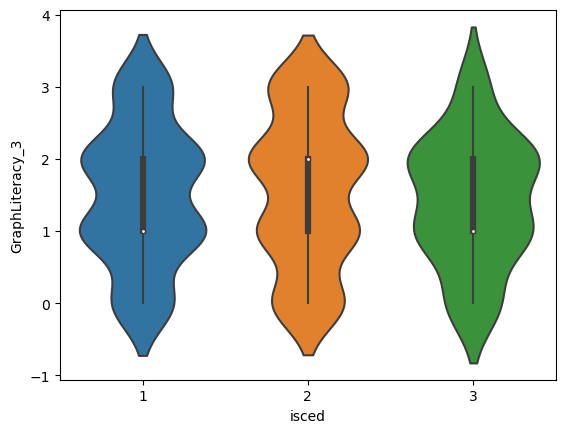

In [93]:
# Violine Plot for GraphLiteracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'GraphLiteracy_3')

<Axes: xlabel='isced', ylabel='Numeracy_3'>

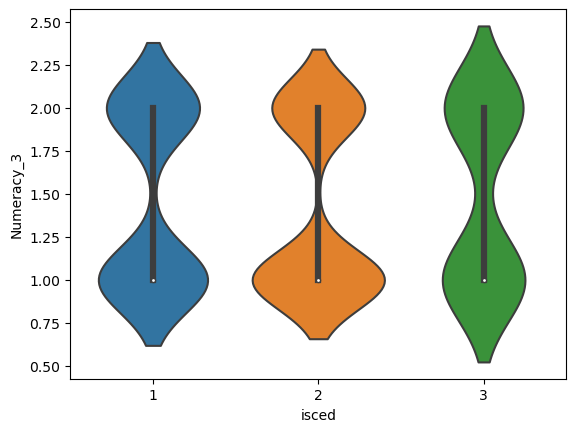

In [94]:
# Violine Plot for Numeracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Numeracy_3')

<Axes: xlabel='isced', ylabel='Bayesianreasoning_1'>

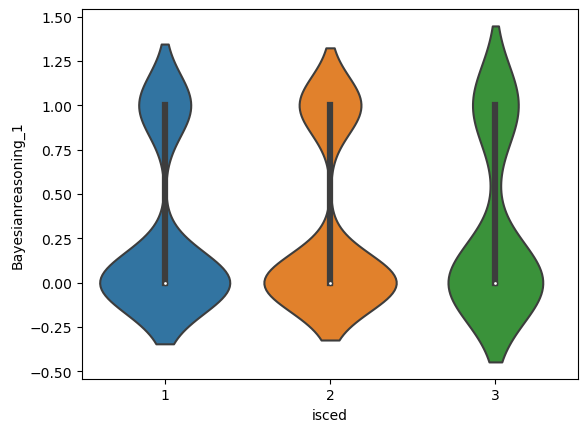

In [95]:
# Violine Plot for TotalScore_14 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Bayesianreasoning_1')

In [96]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df6 = df5.dropna(axis = 0, subset = 'wealth')
# df6.drop(df6[df6['wealth'] == 3500000].index, inplace = True)
df6.loc[df6['isced']==1][['wealth']].describe()

wealth
count  1.260000e+02
mean   4.726376e+06
std    1.304076e+07
min    0.000000e+00
25%    2.000000e+05
50%    1.000000e+06
75%    4.000000e+06
max    1.000000e+08

In [97]:
# Descriptive stats for the data set, isced = 2

df6.loc[df6['isced']==2][['wealth']].describe()

wealth
count  2.010000e+02
mean   5.055470e+06
std    1.647852e+07
min    0.000000e+00
25%    1.000000e+05
50%    5.000000e+05
75%    2.500000e+06
max    1.500000e+08

In [98]:
# Descriptive stats for the data set, isced = 3

df6.loc[df6['isced']==3][['wealth']].describe()

wealth
count  4.300000e+01
mean   4.133750e+06
std    1.532675e+07
min    0.000000e+00
25%    7.000000e+04
50%    4.000000e+05
75%    1.750000e+06
max    1.000000e+08

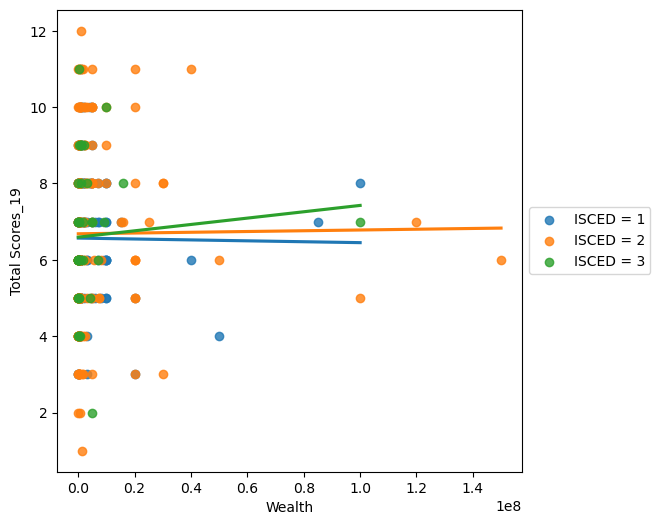

In [99]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='Wealth')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

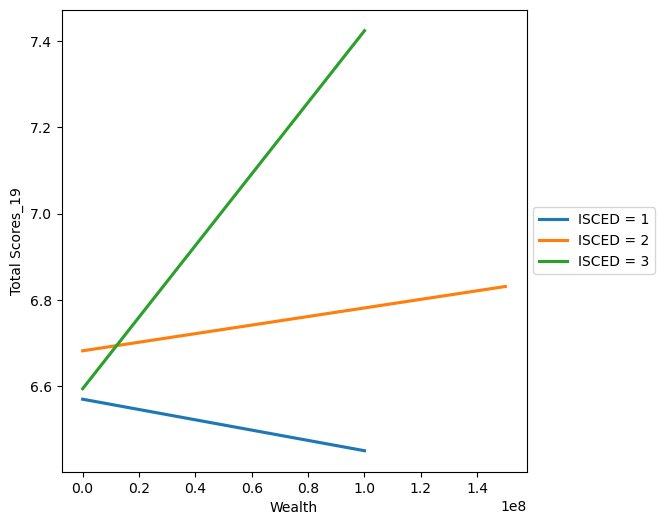

In [100]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='Wealth')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

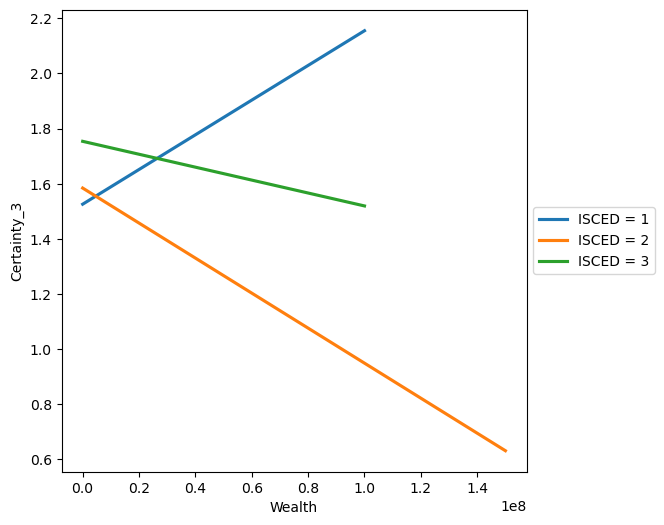

In [101]:
# Trend line for Absolute Certainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_3', xlabel='Wealth')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

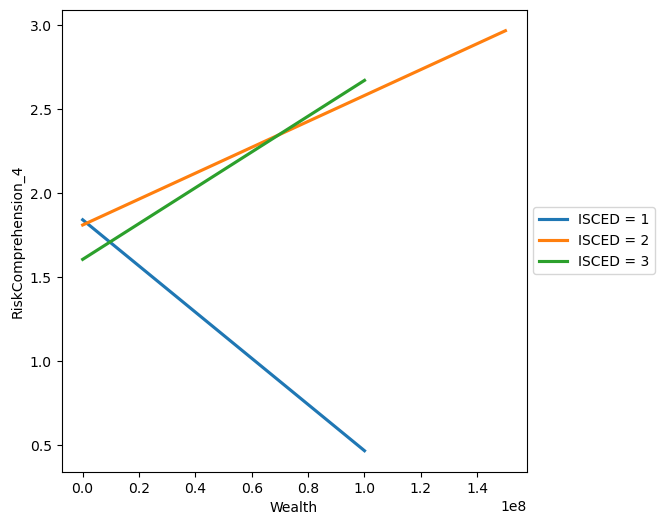

In [102]:
# Trend line for Absolute Uncertainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_4', xlabel='Wealth')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

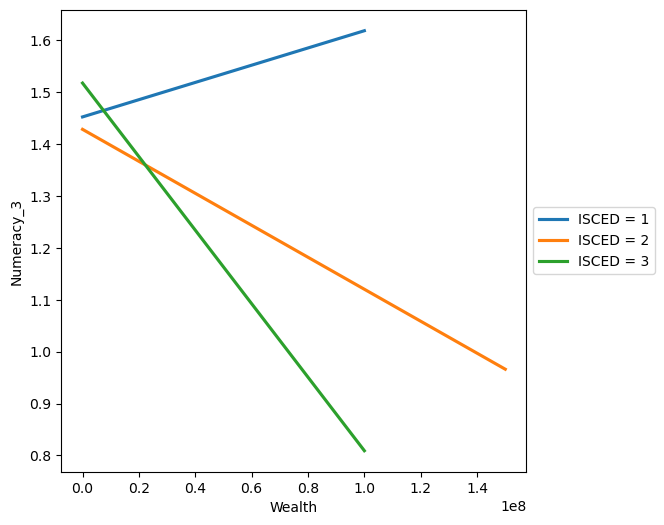

In [103]:
# Trend line for Absolute Number Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

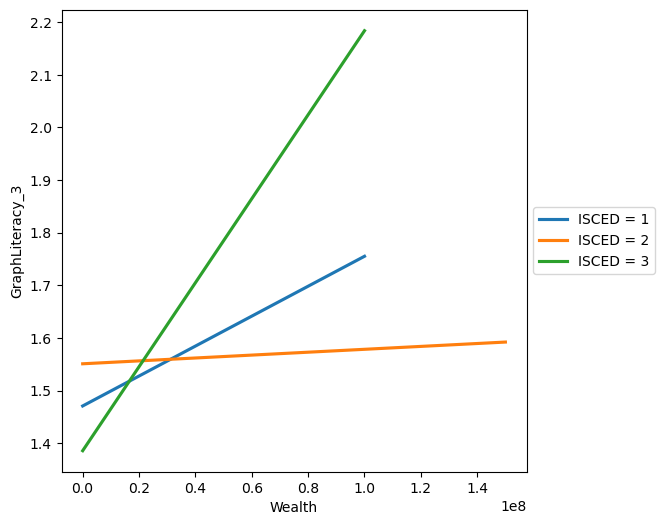

In [104]:
# Trend line for Absolute Graph Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

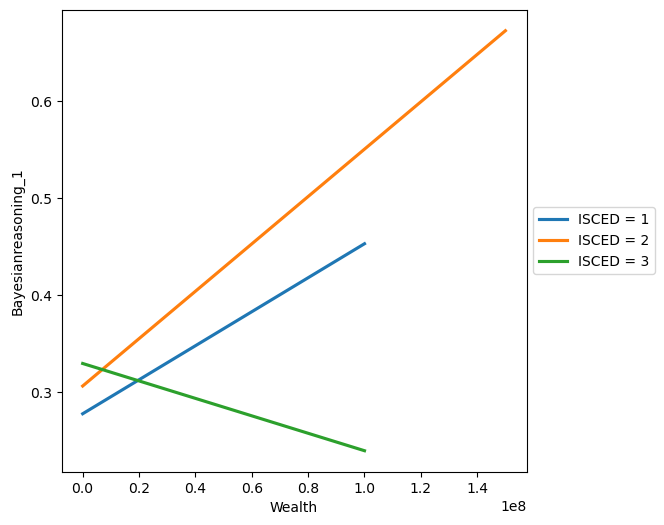

In [105]:
# Trend line for Absolute Bayesian Reasoning Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='Wealth')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [106]:
# Descriptive stats for the data set, isced = 1
# NA values of income are removed

df7 = df5
df7.drop(df7[df7['income'] == 7].index, inplace = True)

df7.loc[df7['isced']==1].describe()

age     age_rec  isced      income        wealth  Certainty_3  \
count  126.000000  126.000000  126.0  126.000000  1.260000e+02   126.000000   
mean    33.087302    2.357143    1.0    1.873016  4.726376e+06     1.555556   
std      9.354374    0.558058    0.0    1.042951  1.304076e+07     0.785423   
min     18.000000    2.000000    1.0    1.000000  0.000000e+00     0.000000   
25%     27.000000    2.000000    1.0    1.000000  2.000000e+05     1.000000   
50%     31.000000    2.000000    1.0    2.000000  1.000000e+06     2.000000   
75%     37.000000    3.000000    1.0    2.000000  4.000000e+06     2.000000   
max     70.000000    4.000000    1.0    5.000000  1.000000e+08     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           126.000000       126.000000  126.000000           126.000000   
mean              1.777778         1.484127    1.460317             0.285714   
std               1.144649         0.952757    0.500413             0.453557   
min               0.000000         0.000000    1.000000             0.000000   
25%               1.000000         1.000000    1.000000             0.000000   
50%               2.000000         1.000000    1.000000             0.000000   
75%               3.000000         2.000000    2.000000             1.000000   
max               4.000000         3.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   126.000000           126.000000       126.000000  126.000000   
mean     51.851852            44.444444        49.470899   48.677249   
std      26.180758            28.616235        31.758569   16.680418   
min       0.000000             0.000000         0.000000   33.333333   
25%      33.333333            25.000000        33.333333   33.333333   
50%      66.666667            50.000000        33.333333   33.333333   
75%      66.666667            75.000000        66.666667   66.666667   
max     100.000000           100.000000       100.000000   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           126.000000     126.000000    126.000000  
mean             28.571429       6.563492     46.882086  
std              45.355737       1.745834     12.470243  
min               0.000000       3.000000     21.428571  
25%               0.000000       5.000000     35.714286  
50%               0.000000       7.000000     50.000000  
75%             100.000000       8.000000     57.142857  
max             100.000000      11.000000     78.571429

In [107]:
df7.loc[df7['isced']==2].describe()

age     age_rec  isced      income        wealth  Certainty_3  \
count  201.000000  201.000000  201.0  201.000000  2.010000e+02   201.000000   
mean    27.716418    2.144279    2.0    1.686567  5.055470e+06     1.552239   
std      8.642579    0.405067    0.0    1.008102  1.647852e+07     0.773633   
min     18.000000    2.000000    2.0    1.000000  0.000000e+00     0.000000   
25%     22.000000    2.000000    2.0    1.000000  1.000000e+05     1.000000   
50%     25.000000    2.000000    2.0    1.000000  5.000000e+05     2.000000   
75%     31.000000    2.000000    2.0    2.000000  2.500000e+06     2.000000   
max     70.000000    4.000000    2.0    5.000000  1.500000e+08     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           201.000000       201.000000  201.000000           201.000000   
mean              1.850746         1.552239    1.412935             0.318408   
std               1.314387         1.033686    0.493591             0.467022   
min               0.000000         0.000000    1.000000             0.000000   
25%               1.000000         1.000000    1.000000             0.000000   
50%               2.000000         2.000000    1.000000             0.000000   
75%               3.000000         2.000000    2.000000             1.000000   
max               4.000000         3.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   201.000000           201.000000       201.000000  201.000000   
mean     51.741294            46.268657        51.741294   47.097844   
std      25.787755            32.859663        34.456212   16.453025   
min       0.000000             0.000000         0.000000   33.333333   
25%      33.333333            25.000000        33.333333   33.333333   
50%      66.666667            50.000000        66.666667   33.333333   
75%      66.666667            75.000000        66.666667   66.666667   
max     100.000000           100.000000       100.000000   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           201.000000     201.000000    201.000000  
mean             31.840796       6.686567     47.761194  
std              46.702190       2.268539     16.203849  
min               0.000000       1.000000      7.142857  
25%               0.000000       5.000000     35.714286  
50%               0.000000       6.000000     42.857143  
75%             100.000000       8.000000     57.142857  
max             100.000000      12.000000     85.714286

In [108]:
df7.loc[df7['isced']==3].describe()

age    age_rec  isced     income        wealth  Certainty_3  \
count  43.000000  43.000000   43.0  43.000000  4.300000e+01    43.000000   
mean   22.255814   2.046512    3.0   1.767442  4.133750e+06     1.744186   
std     6.959382   0.433891    0.0   1.250471  1.532675e+07     0.758853   
min    16.000000   0.000000    3.0   1.000000  0.000000e+00     0.000000   
25%    18.000000   2.000000    3.0   1.000000  7.000000e+04     2.000000   
50%    19.000000   2.000000    3.0   1.000000  4.000000e+05     2.000000   
75%    22.000000   2.000000    3.0   2.000000  1.750000e+06     2.000000   
max    46.000000   3.000000    3.0   5.000000  1.000000e+08     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count            43.000000        43.000000   43.000000            43.000000   
mean              1.651163         1.418605    1.488372             0.325581   
std               1.307191         0.879192    0.505781             0.474137   
min               0.000000         0.000000    1.000000             0.000000   
25%               1.000000         1.000000    1.000000             0.000000   
50%               1.000000         1.000000    1.000000             0.000000   
75%               3.000000         2.000000    2.000000             1.000000   
max               4.000000         3.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    43.000000            43.000000        43.000000   43.000000   
mean     58.139535            41.279070        47.286822   49.612403   
std      25.295108            32.679778        29.306407   16.859351   
min       0.000000             0.000000         0.000000   33.333333   
25%      66.666667            25.000000        33.333333   33.333333   
50%      66.666667            25.000000        33.333333   33.333333   
75%      66.666667            75.000000        66.666667   66.666667   
max     100.000000           100.000000       100.000000   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            43.000000      43.000000     43.000000  
mean             32.558140       6.627907     47.342193  
std              47.413732       1.826045     13.043179  
min               0.000000       2.000000     14.285714  
25%               0.000000       6.000000     42.857143  
50%               0.000000       6.000000     42.857143  
75%             100.000000       8.000000     57.142857  
max             100.000000      11.000000     78.571429

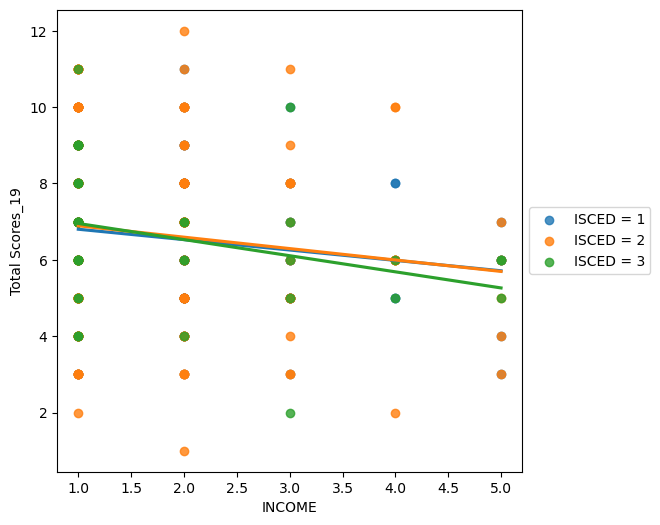

In [109]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==1]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==2]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==3]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='INCOME')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

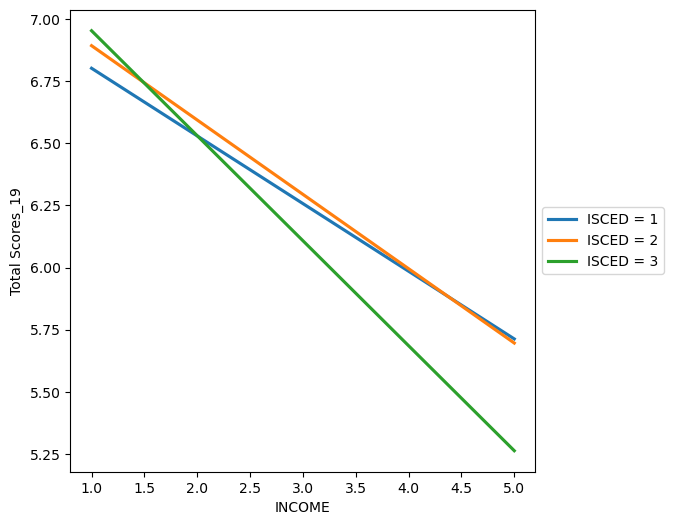

In [110]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='INCOME')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

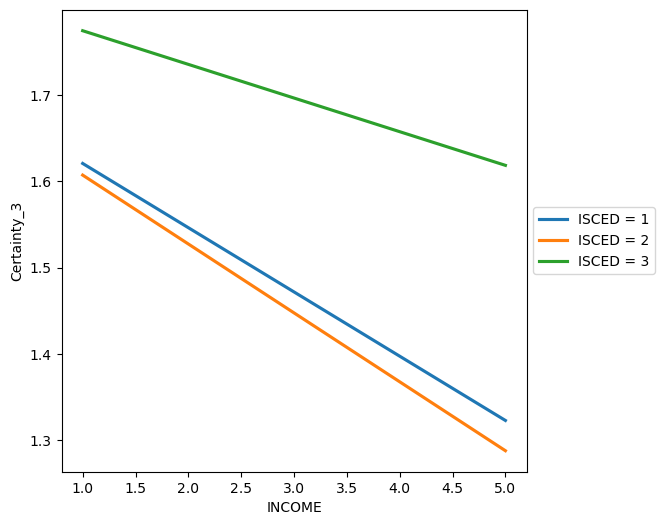

In [111]:
# Trend line for Absolute Certainty Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_3', xlabel='INCOME')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

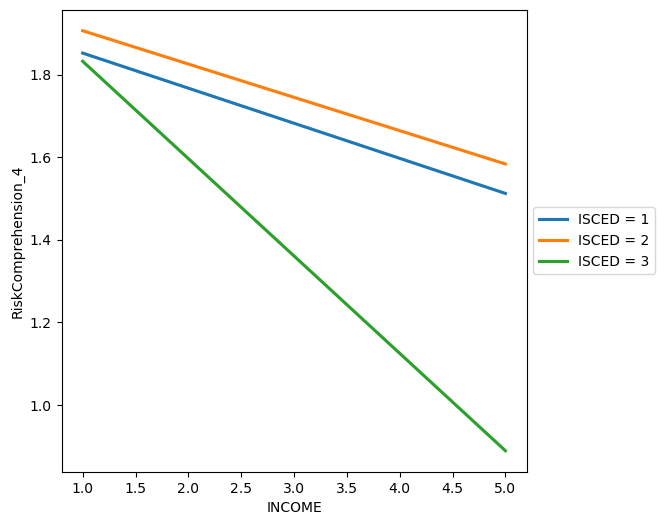

In [112]:
# Trend line for Absolute Risk Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_4', xlabel='INCOME')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

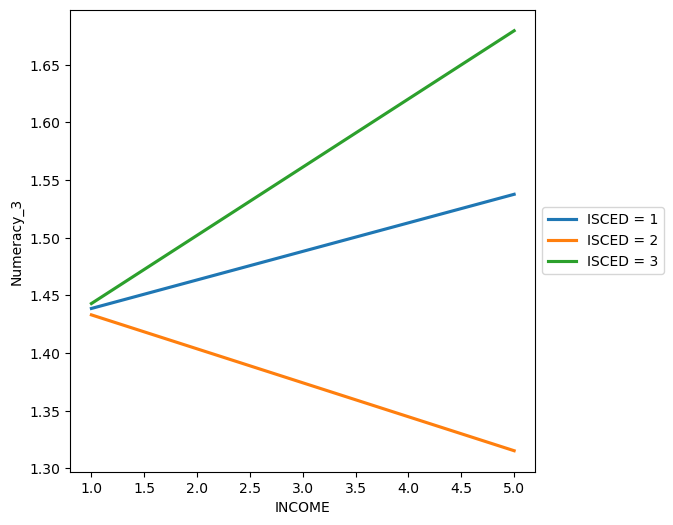

In [113]:
# Trend line for Absolute Number Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

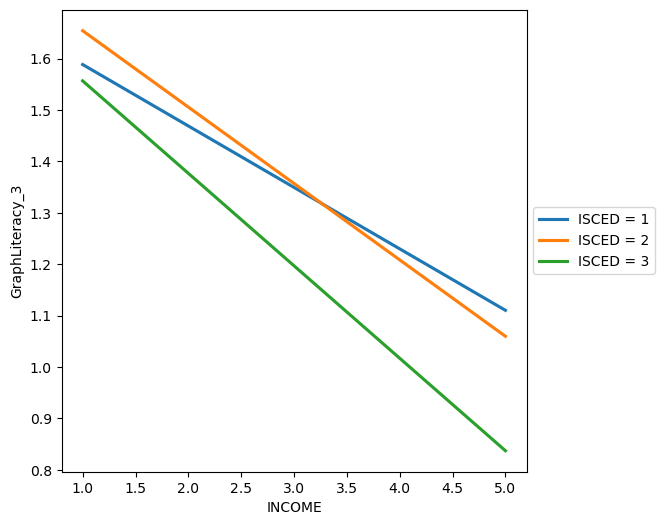

In [114]:
# Trend line for Absolute Graph Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

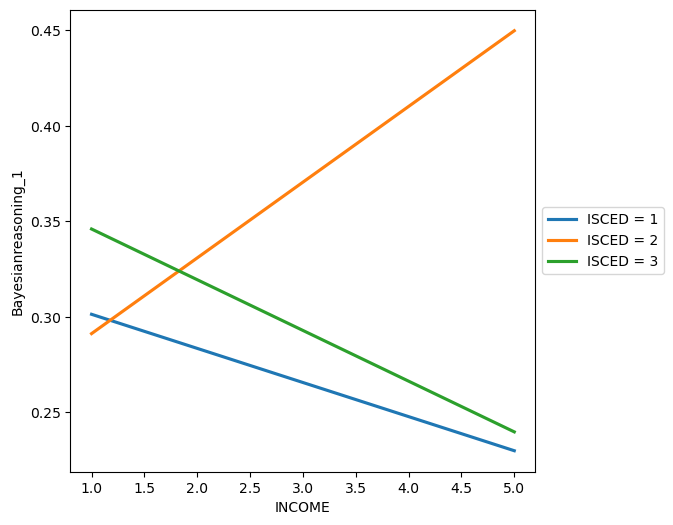

In [115]:
# Trend line for Absolute Bayesian Reasoning Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='INCOME')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [116]:
df7

ResponseId  age  age_rec  isced  income      wealth  Certainty_3  \
0    R_4XhfVqNhg49zZXe   37        3      1       2   6000000.0            2   
1    R_4FjN0R9SXA0s0G5   53        3      1       2   5000000.0            2   
2    R_4Ph1UNtYnaoPSX7   25        2      1       3    400000.0            0   
3    R_4FVQvDpbnyvqOQY   28        2      1       2   3200000.0            0   
4    R_4PjnTbc2vIjogot   31        2      1       1    200000.0            2   
..                 ...  ...      ...    ...     ...         ...          ...   
365  R_4fkCPjfYl6UggHL   18        2      3       1   1000000.0            2   
366  R_4K6WL8dnMy7ODbs   18        2      3       5    100000.0            2   
367  R_4ANgmQQx8TBl3kc   21        2      3       1  16000000.0            0   
368  R_4MJAzsNYYA69Y8p   27        2      3       1         0.0            2   
369  R_4EneslabJXcCOT4   18        2      3       1   3000000.0            2   

     RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                      0                1           2                    0   
1                      2                1           1                    1   
2                      2                0           1                    0   
3                      1                0           2                    0   
4                      1                0           1                    0   
..                   ...              ...         ...                  ...   
365                    3                1           2                    1   
366                    0                1           2                    0   
367                    4                2           1                    1   
368                    1                1           2                    1   
369                    3                2           1                    0   

     Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0      66.666667                  0.0        33.333333   66.666667   
1      66.666667                 50.0        33.333333   33.333333   
2       0.000000                 50.0         0.000000   33.333333   
3       0.000000                 25.0         0.000000   66.666667   
4      66.666667                 25.0         0.000000   33.333333   
..           ...                  ...              ...         ...   
365    66.666667                 75.0        33.333333   66.666667   
366    66.666667                  0.0        33.333333   66.666667   
367     0.000000                100.0        66.666667   33.333333   
368    66.666667                 25.0        33.333333   66.666667   
369    66.666667                 75.0        66.666667   33.333333   

     Bayesianreasoning_%  TotalScore_14  TotalScore_%  
0                    0.0              5     35.714286  
1                  100.0              7     50.000000  
2                    0.0              3     21.428571  
3                    0.0              3     21.428571  
4                    0.0              4     28.571429  
..                   ...            ...           ...  
365                100.0              9     64.285714  
366                  0.0              5     35.714286  
367                100.0              8     57.142857  
368                100.0              7     50.000000  
369                  0.0              8     57.142857  

[370 rows x 18 columns]

In [117]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [118]:
df7.loc[(df7['age_rec']==2)].describe()

age  age_rec       isced      income        wealth  Certainty_3  \
count  300.000000    300.0  300.000000  300.000000  3.000000e+02   300.000000   
mean    25.443333      2.0    1.840000    1.730000  4.961460e+06     1.576667   
std      4.879839      0.0    0.623723    1.042781  1.650114e+07     0.765556   
min     18.000000      2.0    1.000000    1.000000  0.000000e+00     0.000000   
25%     21.000000      2.0    1.000000    1.000000  1.000000e+05     1.000000   
50%     25.000000      2.0    2.000000    1.000000  5.000000e+05     2.000000   
75%     29.000000      2.0    2.000000    2.000000  2.500000e+06     2.000000   
max     35.000000      2.0    3.000000    5.000000  1.500000e+08     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count           300.000000       300.000000  300.000000           300.000000   
mean              1.810000         1.536667    1.443333             0.313333   
std               1.280377         0.999325    0.497609             0.464624   
min               0.000000         0.000000    1.000000             0.000000   
25%               1.000000         1.000000    1.000000             0.000000   
50%               2.000000         2.000000    1.000000             0.000000   
75%               3.000000         2.000000    2.000000             1.000000   
max               4.000000         3.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count   300.000000           300.000000       300.000000  300.000000   
mean     52.555556            45.250000        51.222222   48.111111   
std      25.518529            32.009418        33.310843   16.586952   
min       0.000000             0.000000         0.000000   33.333333   
25%      33.333333            25.000000        33.333333   33.333333   
50%      66.666667            50.000000        66.666667   33.333333   
75%      66.666667            75.000000        66.666667   66.666667   
max     100.000000           100.000000       100.000000   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count           300.000000     300.000000    300.000000  
mean             31.333333       6.680000     47.714286  
std              46.462365       2.081355     14.866824  
min               0.000000       1.000000      7.142857  
25%               0.000000       5.000000     35.714286  
50%               0.000000       6.000000     42.857143  
75%             100.000000       8.000000     57.142857  
max             100.000000      12.000000     85.714286

In [119]:
df7.loc[(df7['age_rec']==3)].describe()

age  age_rec      isced     income        wealth  Certainty_3  \
count  60.000000     60.0  60.000000  60.000000  6.000000e+01    60.000000   
mean   41.366667      3.0   1.483333   1.800000  4.168683e+06     1.583333   
std     5.108871      0.0   0.624138   0.988064  8.074776e+06     0.808675   
min    36.000000      3.0   1.000000   1.000000  1.000000e+03     0.000000   
25%    37.000000      3.0   1.000000   1.000000  1.500000e+05     1.750000   
50%    40.000000      3.0   1.000000   2.000000  1.000000e+06     2.000000   
75%    44.000000      3.0   2.000000   2.000000  5.000000e+06     2.000000   
max    54.000000      3.0   3.000000   5.000000  5.000000e+07     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count            60.000000        60.000000   60.000000            60.000000   
mean              1.716667         1.450000    1.366667             0.316667   
std               1.180228         0.946447    0.485961             0.469102   
min               0.000000         0.000000    1.000000             0.000000   
25%               1.000000         1.000000    1.000000             0.000000   
50%               2.000000         1.000000    1.000000             0.000000   
75%               3.000000         2.000000    2.000000             1.000000   
max               4.000000         3.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    60.000000            60.000000        60.000000   60.000000   
mean     52.777778            42.916667        48.333333   45.555556   
std      26.955824            29.505697        31.548247   16.198703   
min       0.000000             0.000000         0.000000   33.333333   
25%      58.333333            25.000000        33.333333   33.333333   
50%      66.666667            50.000000        33.333333   33.333333   
75%      66.666667            75.000000        66.666667   66.666667   
max     100.000000           100.000000       100.000000   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            60.000000      60.000000     60.000000  
mean             31.666667       6.433333     45.952381  
std              46.910180       2.011549     14.368204  
min               0.000000       2.000000     14.285714  
25%               0.000000       5.000000     35.714286  
50%               0.000000       6.500000     46.428571  
75%             100.000000       8.000000     57.142857  
max             100.000000      11.000000     78.571429

In [120]:
df7.loc[(df7['age_rec']==4)].describe()

age  age_rec     isced    income        wealth  Certainty_3  \
count   9.000000      9.0  9.000000  9.000000  9.000000e+00     9.000000   
mean   62.888889      4.0  1.444444  2.555556  5.651667e+06     1.333333   
std     4.567397      0.0  0.527046  1.509231  4.226837e+06     0.866025   
min    57.000000      4.0  1.000000  1.000000  3.500000e+05     0.000000   
25%    61.000000      4.0  1.000000  2.000000  5.500000e+05     1.000000   
50%    61.000000      4.0  1.000000  2.000000  7.000000e+06     2.000000   
75%    65.000000      4.0  2.000000  3.000000  1.000000e+07     2.000000   
max    70.000000      4.0  2.000000  5.000000  1.000000e+07     2.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count             9.000000         9.000000    9.000000             9.000000   
mean              2.222222         1.333333    1.666667             0.111111   
std               0.971825         0.866025    0.500000             0.333333   
min               0.000000         0.000000    1.000000             0.000000   
25%               2.000000         1.000000    1.000000             0.000000   
50%               2.000000         2.000000    2.000000             0.000000   
75%               3.000000         2.000000    2.000000             0.000000   
max               3.000000         2.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count     9.000000             9.000000         9.000000    9.000000   
mean     44.444444            55.555556        44.444444   55.555556   
std      28.867513            24.295633        28.867513   16.666667   
min       0.000000             0.000000         0.000000   33.333333   
25%      33.333333            50.000000        33.333333   33.333333   
50%      66.666667            50.000000        66.666667   66.666667   
75%      66.666667            75.000000        66.666667   66.666667   
max      66.666667            75.000000        66.666667   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count             9.000000       9.000000      9.000000  
mean             11.111111       6.666667     47.619048  
std              33.333333       1.322876      9.449112  
min               0.000000       5.000000     35.714286  
25%               0.000000       6.000000     42.857143  
50%               0.000000       7.000000     50.000000  
75%               0.000000       7.000000     50.000000  
max             100.000000       9.000000     64.285714

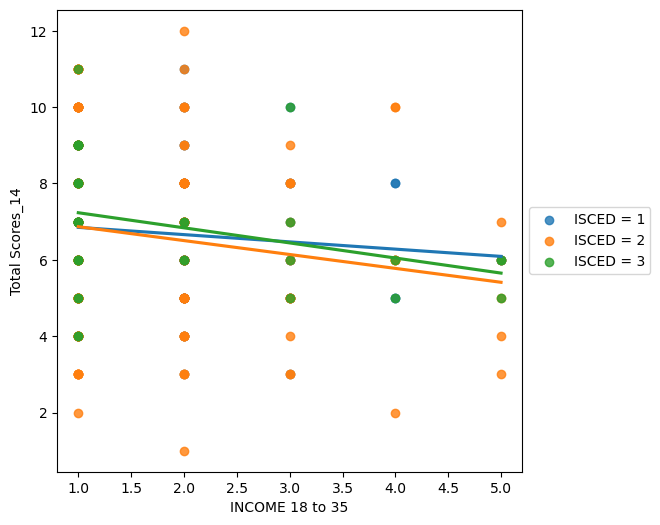

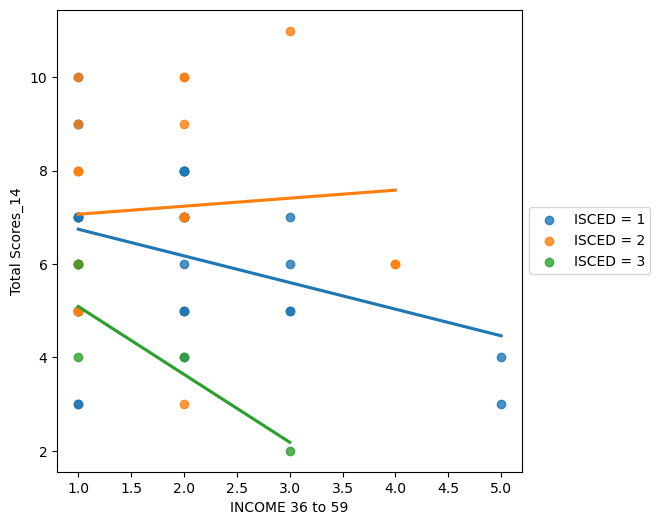

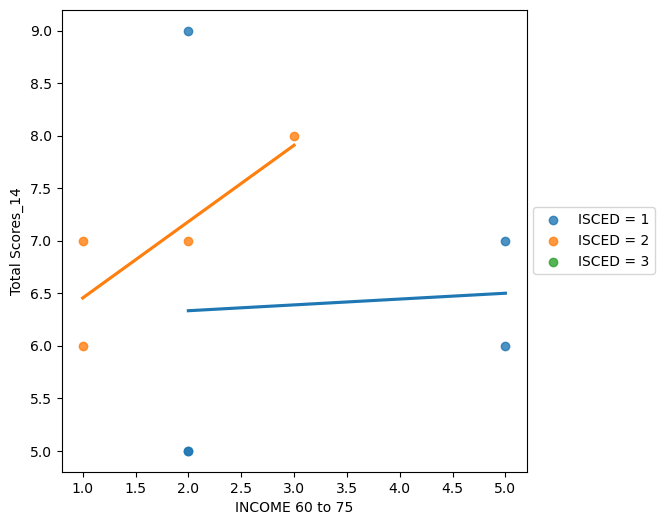

In [121]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='INCOME 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME 36 to 59')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME 60 to 75')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

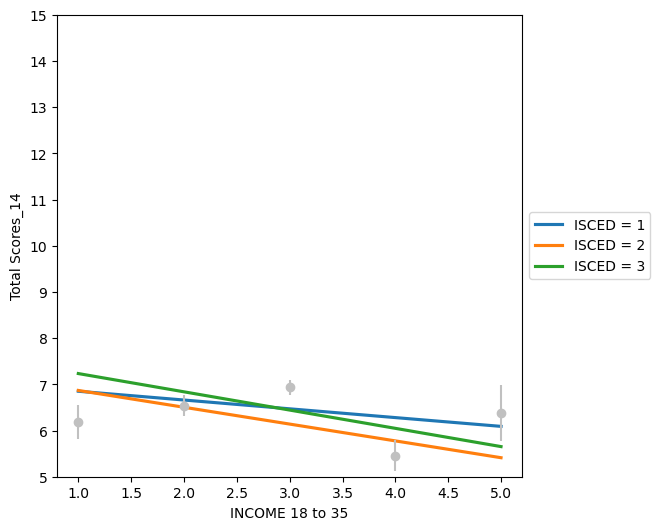

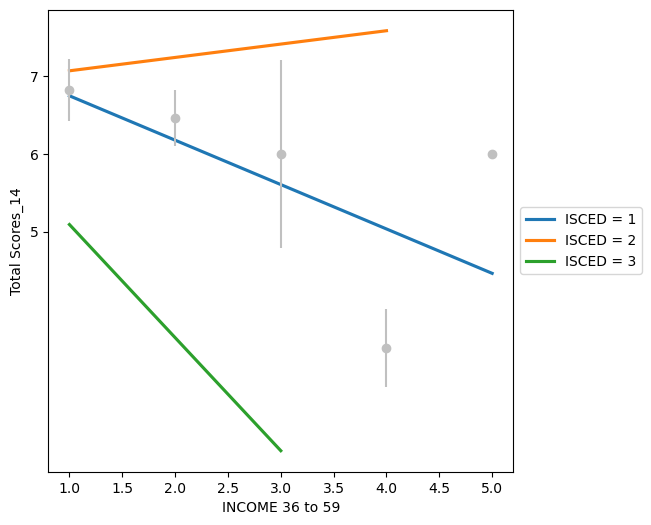

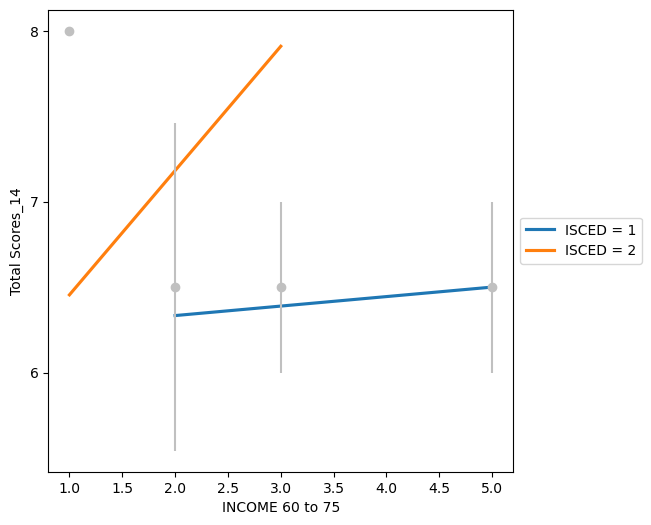

In [122]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='INCOME 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME 36 to 59',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME 60 to 75',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

ValueError: 'x' and 'y' must have the same size

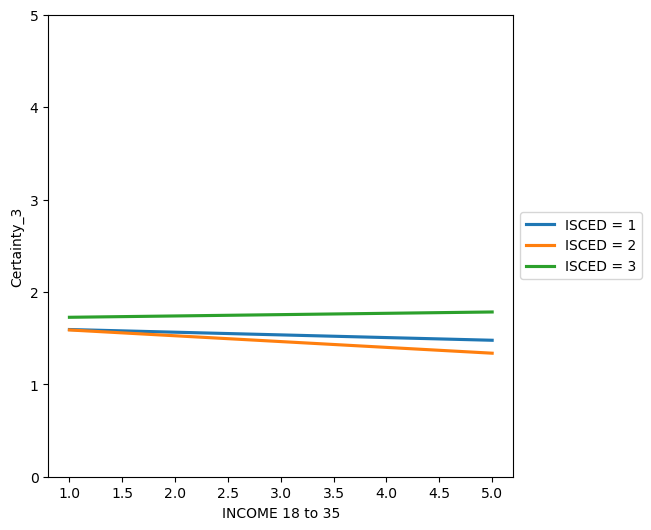

In [123]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_4', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_4', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_4', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [ ]:
# Age median method
# Age_median

In [ ]:
age_m = df1["age"].median()
age_m

In [ ]:
df7["income"].value_counts()

In [ ]:
df7.loc[(df7['age'] < age_m)].describe()

In [ ]:
df7.loc[(df7['age'] > age_m)].describe()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='INCOME for > median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['TotalScore_14'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['TotalScore_14'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='INCOME for > median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_3', xlabel='INCOME for > median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_4', xlabel='INCOME for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_4', xlabel='INCOME for > median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_3', xlabel='INCOME for > median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for > median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for > median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()